In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


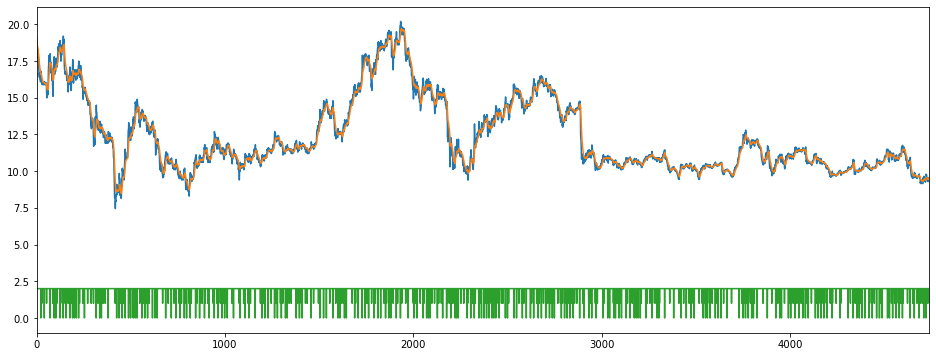

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0

In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4720, 20, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4720, 20, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4720, 20, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4720, 20, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4720, 64, 64, 1)

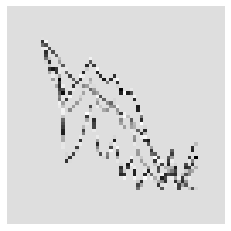

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [244]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [245]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.317829457364341, 1: 7.403921568627451, 2: 0.36653077072413126}
Epoch 1/200
30/30 [==============================] - 2s 79ms/step - loss: 0.2419 - accuracy: 0.3665 - mse: 1.6651 - weighted_accuracy: 0.3288 - weighted_mse: 1.7120 - val_loss: 0.2054 - val_accuracy: 0.0636 - val_mse: 0.9050 - val_weighted_accuracy: 0.0636 - val_weighted_mse: 0.9050
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2073 - accuracy: 0.2233 - mse: 1.1829 - weighted_accuracy: 0.3177 - weighted_mse: 1.1744 - val_loss: 0.2139 - val_accuracy: 0.0456 - val_mse: 0.9210 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.9210
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2066 - accuracy: 0.2172 - mse: 1.1914 - weighted_accuracy: 0.3341 - weighted_mse: 1.1644 - val_loss: 0.2094 - val_accuracy: 0.0456 - val_mse: 0.9219 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.9219
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.201

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1784 - accuracy: 0.1459 - mse: 1.3102 - weighted_accuracy: 0.5056 - weighted_mse: 1.2694 - val_loss: 0.1976 - val_accuracy: 0.1081 - val_mse: 1.0884 - val_weighted_accuracy: 0.1081 - val_weighted_mse: 1.0884
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1774 - accuracy: 0.1478 - mse: 1.3124 - weighted_accuracy: 0.5061 - weighted_mse: 1.2642 - val_loss: 0.2015 - val_accuracy: 0.0805 - val_mse: 1.0919 - val_weighted_accuracy: 0.0805 - val_weighted_mse: 1.0919
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1785 - accuracy: 0.1372 - mse: 1.2814 - weighted_accuracy: 0.5062 - weighted_mse: 1.2491 - val_loss: 0.1995 - val_accuracy: 0.0794 - val_mse: 1.0344 - val_weighted_accuracy: 0.0794 - val_weighted_mse: 1.0344
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1771 - accuracy: 0.1494 - mse: 1.3141 - weighted_accuracy: 0.5106 - 

Epoch 114/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1461 - accuracy: 0.2842 - mse: 1.6907 - weighted_accuracy: 0.6024 - weighted_mse: 1.7906 - val_loss: 0.1881 - val_accuracy: 0.3347 - val_mse: 1.3714 - val_weighted_accuracy: 0.3347 - val_weighted_mse: 1.3714
Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1443 - accuracy: 0.2929 - mse: 1.6362 - weighted_accuracy: 0.6281 - weighted_mse: 1.7307 - val_loss: 0.1893 - val_accuracy: 0.2818 - val_mse: 1.3338 - val_weighted_accuracy: 0.2818 - val_weighted_mse: 1.3338
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1422 - accuracy: 0.3008 - mse: 1.6443 - weighted_accuracy: 0.6346 - weighted_mse: 1.7700 - val_loss: 0.1879 - val_accuracy: 0.3432 - val_mse: 1.4291 - val_weighted_accuracy: 0.3432 - val_weighted_mse: 1.4291
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1448 - accuracy: 0.2948 - mse: 1.6733 - weighted_accuracy: 0.6046 

Epoch 143/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1350 - accuracy: 0.4017 - mse: 1.8849 - weighted_accuracy: 0.6475 - weighted_mse: 2.1725 - val_loss: 0.1709 - val_accuracy: 0.4989 - val_mse: 1.6139 - val_weighted_accuracy: 0.4989 - val_weighted_mse: 1.6139
Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1322 - accuracy: 0.4076 - mse: 1.8957 - weighted_accuracy: 0.6534 - weighted_mse: 2.2462 - val_loss: 0.1730 - val_accuracy: 0.4640 - val_mse: 1.5432 - val_weighted_accuracy: 0.4640 - val_weighted_mse: 1.5432
Epoch 145/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1363 - accuracy: 0.4057 - mse: 1.8544 - weighted_accuracy: 0.6379 - weighted_mse: 2.1529 - val_loss: 0.1690 - val_accuracy: 0.5064 - val_mse: 1.5876 - val_weighted_accuracy: 0.5064 - val_weighted_mse: 1.5876
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1323 - accuracy: 0.4100 - mse: 1.9276 - weighted_accuracy: 0.674

Epoch 172/200
30/30 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.5354 - mse: 2.2219 - weighted_accuracy: 0.7191 - weighted_mse: 2.935 - 0s 9ms/step - loss: 0.1187 - accuracy: 0.5344 - mse: 2.2239 - weighted_accuracy: 0.7221 - weighted_mse: 2.9448 - val_loss: 0.1488 - val_accuracy: 0.6557 - val_mse: 1.7554 - val_weighted_accuracy: 0.6557 - val_weighted_mse: 1.7554
Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1195 - accuracy: 0.5156 - mse: 2.2941 - weighted_accuracy: 0.7244 - weighted_mse: 2.9837 - val_loss: 0.1428 - val_accuracy: 0.6928 - val_mse: 1.7879 - val_weighted_accuracy: 0.6928 - val_weighted_mse: 1.7879
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1196 - accuracy: 0.5307 - mse: 2.3380 - weighted_accuracy: 0.7262 - weighted_mse: 3.0776 - val_loss: 0.1449 - val_accuracy: 0.6843 - val_mse: 1.7828 - val_weighted_accuracy: 0.6843 - val_weighted_mse: 1.7828
Epoch 175/200
30/30 [===============

In [246]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1334504336118698
Test accuracy: 0.7362288236618042


In [247]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.1596773  -0.5936688  -0.26153404]
 [-0.4148188  -2.34055    -0.42109078]
 [-2.175568   -0.5377617  -0.2995925 ]
 ...
 [-1.9287543  -0.6682954  -0.26363552]
 [-0.7703116  -1.5099763  -0.14828819]
 [-0.8737916  -1.7273086  -0.1069616 ]]


Counter({2: 745, 0: 99, 1: 100})

In [248]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 858, 0: 43, 1: 43})

In [249]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 944
actual predicted buys: 13
actual buys but predicted sell: 0
actual buys but predicted hold: 30
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 38
actual holds but predicted buy: 87
actual holds but predicted sell: 94
actual predicted holds: 677
Percentage buys correct: 30.232558139534884%
Percentage sells correct: 11.627906976744185%
Percentage holds correct: 78.9044289044289%
actual buys: 43
actual sells: 43
actual holds: 858


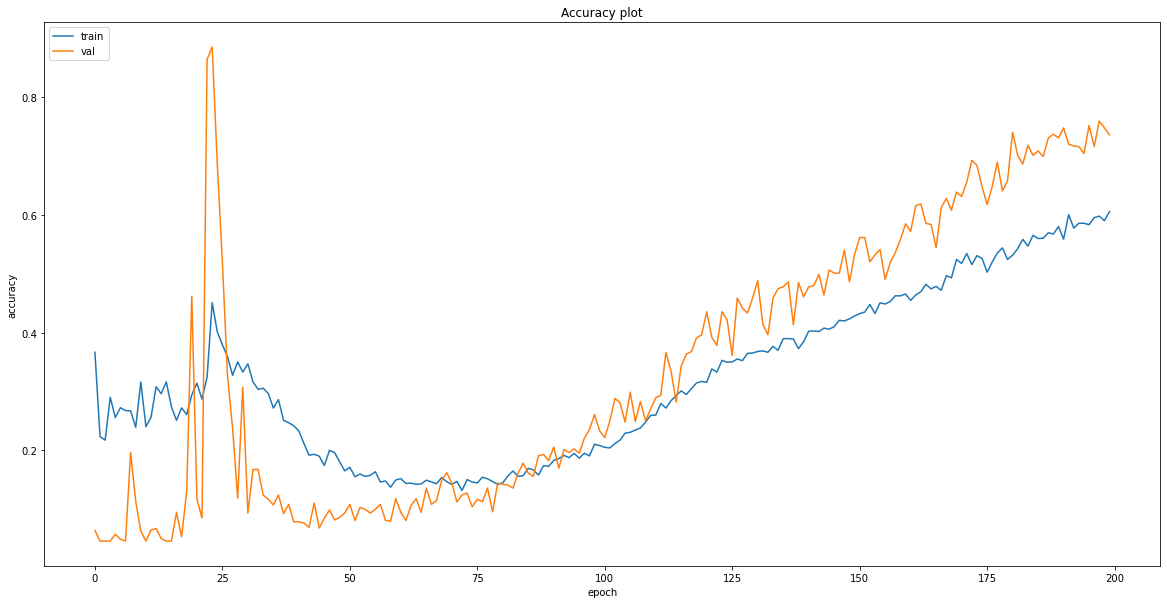

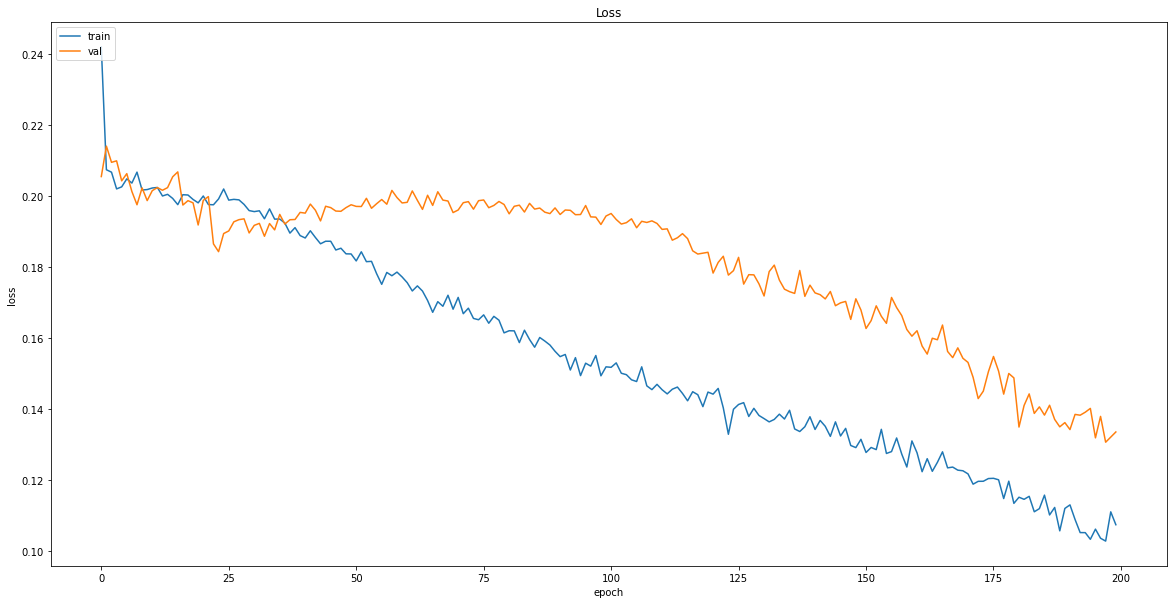

In [250]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [251]:
# Save model
model.save("models/{}".format('Singapore_Airlines_image_cnn_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/Singapore_Airlines_image_cnn_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [252]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


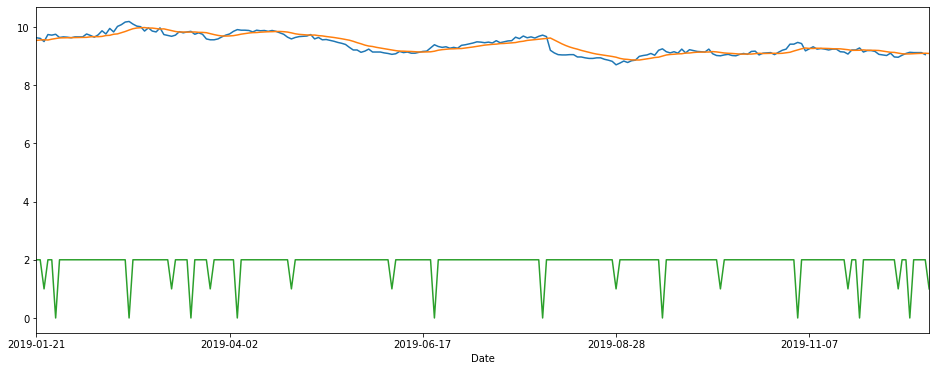

In [253]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [254]:
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
df2.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [255]:
df2 = df2.iloc[-5:]
df2.head(20)

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2018-12-14         9.52  9.466080 -53.571343 -82078567.0     2.0
2018-12-17         9.33  9.445145 -87.500043 -84305791.0     2.0
2018-12-18         9.45  9.445892 -64.814890 -82764591.0     2.0
2018-12-19         9.39  9.437293 -75.925903 -84460291.0     2.0
2018-12-20         9.37  9.426940 -75.000054 -85913091.0     2.0

In [256]:
df2 = pd.concat([df2,df])
df2.head(20)

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2018-12-14         9.52  9.466080 -53.571343 -82078567.0     2.0
2018-12-17         9.33  9.445145 -87.500043 -84305791.0     2.0
2018-12-18         9.45  9.445892 -64.814890 -82764591.0     2.0
2018-12-19         9.39  9.437293 -75.925903 -84460291.0     2.0
2018-12-20         9.37  9.426940 -75.000054 -85913091.0     2.0
2019-01-21         9.59  9.538960 -32.758553   6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007   7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362   7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822   6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884   8160300.0     2.0
2019-01-28         9.72  9.602493 -20.000000   7026900.0     0.0
2019-01-29         9.75  9.625186 -15.000083   7689700.0     2.0
2019-01-30         9.64  9.627465 -51.515038   6232300.0     2.0
2019-01-31         9.66  9.632471 -45.454598   7395400.0     2.0
2019-02-01         9.65  9.635167 -48.484962   5664000.0     2.0
2019-02-04         9.63  9.634372 -54.545402   4627100.0     2.0
2019-02-05         9.66  9.638315 -45.454598   5084100.0     2.0
2019-02-07         9.66  9.641651 -45.454598   5084100.0     2.0
2019-02-08         9.66  9.644474 -45.454598   5084100.0     2.0
2019-02-11         9.76  9.662247 -15.151533   6464788.0     2.0

In [257]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [258]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [259]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [260]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [261]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [262]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1308 - accuracy: 0.7431 - mean_squared_error: 2.1525 - weighted_accuracy: 0.7431 - weighted_mean_squared_error: 2.1525
Test loss: 0.13083890080451965
Test accuracy: 0.7431192398071289


In [263]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 0: 21, 1: 23})

In [264]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [265]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-265-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-265-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-265-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2019-02-11         9.71  9.662247 -15.151533  6464788.0     2.0            2   
2019-02-12         9.65  9.669594 -30.303065  5675088.0     2.0            2   
2019-02-13         9.73  9.666579 -48.484962  4337188.0     2.0            2   
2019-02-14         9.87  9.676336 -32.000351  5826588.0     2.0            0   
2019-02-15         9.76  9.706131  -6.250130  8384988.0     2.0            2   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       2

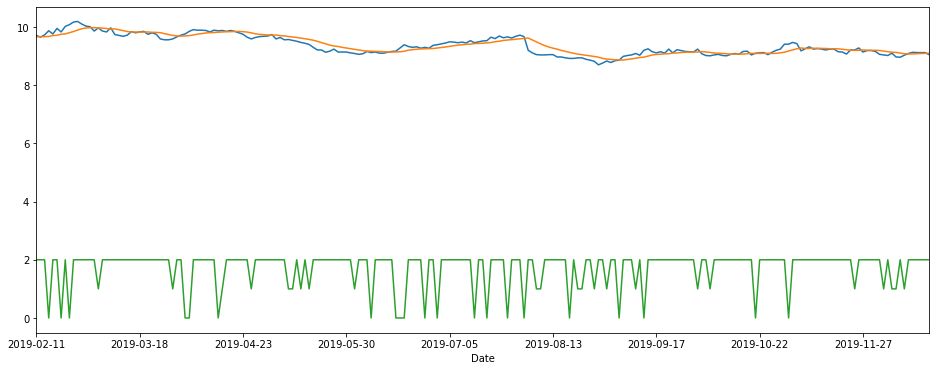

In [266]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

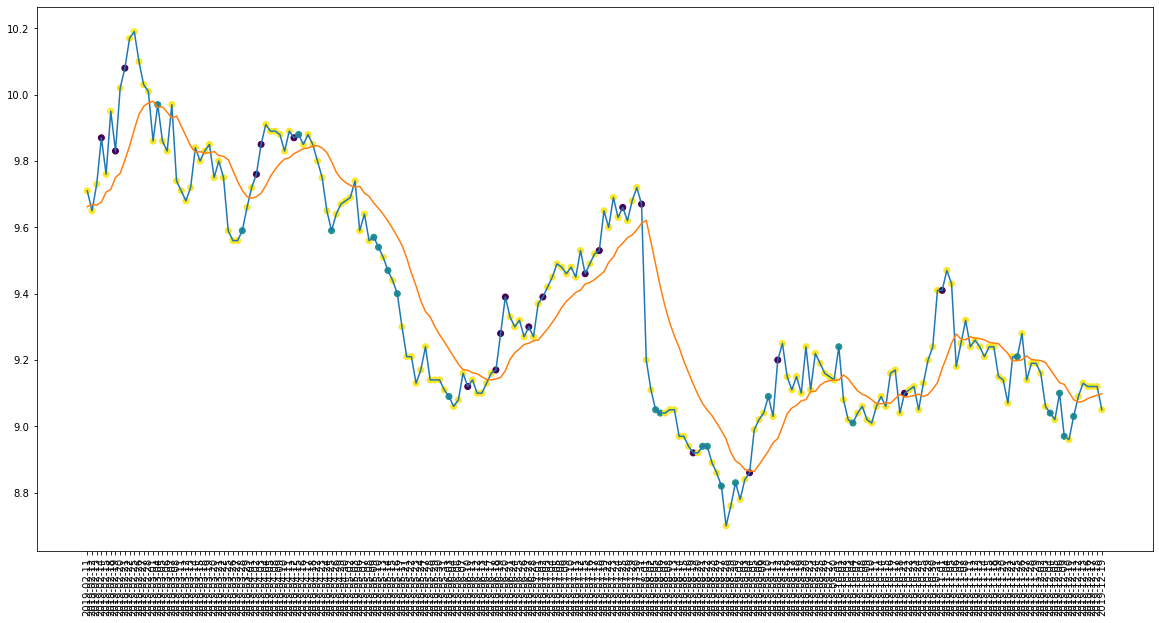

In [267]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

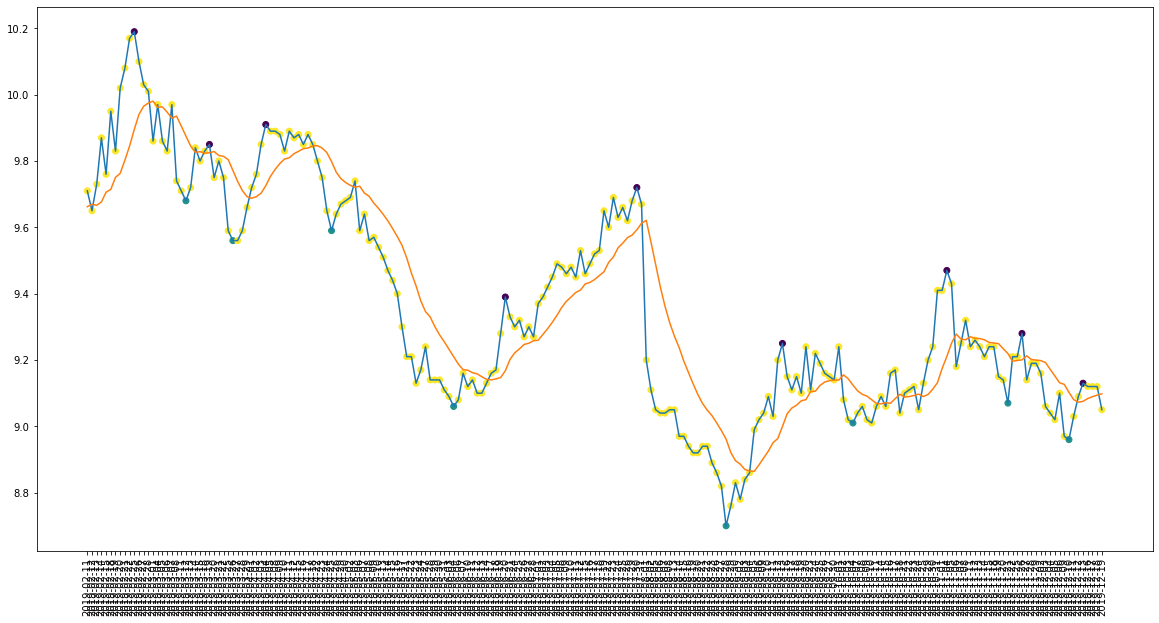

In [268]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [269]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 20
actual predicted holds: 159
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 79.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [270]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 43.47826086956522%
Percentage sells correct: 28.571428571428573%
Percentage holds correct: 77.45664739884393%


In [271]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.970000267028807
Shares owned at the moment: 1000
Cash capital at the moment: $2.5822322368640016


Stop Loss Activated!

Share price: $9.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9655.96253657341


Share price: $9.59000015258789
Shares owned at the moment: 1004
Cash capital at the moment: $1.1243929538723023


Stop Loss Activated!

Share price: $9.300000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9312.647283925056


Share price: $9.09000015258789
Shares owned at the moment: 1021
Cash capital at the moment: $6.234680204390315


Price increase from previously bought: 5.979180852830801%
Share price: $9.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9841.971659840583


Share price: $9.050000190734863
Shares owned at the moment: 1084
Cash capital at the moment: $4.79340251540998


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $

In [272]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


### Recession

In [273]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


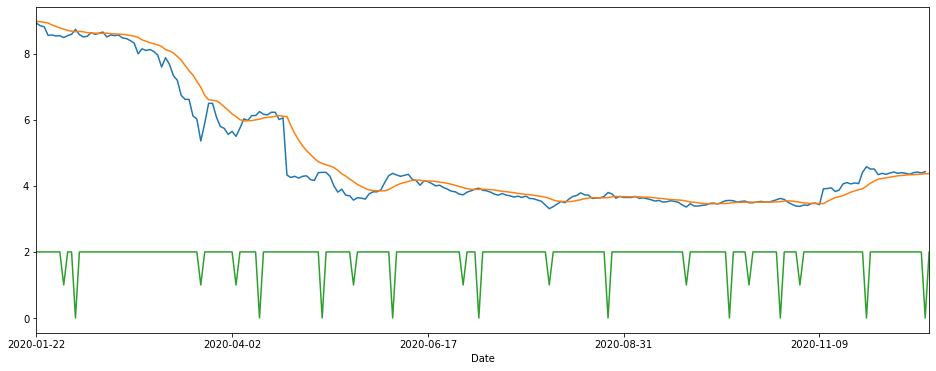

In [274]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [275]:
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])

In [276]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [277]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [278]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [279]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [280]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [281]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1302 - accuracy: 0.8000 - mean_squared_error: 2.1785 - weighted_accuracy: 0.8000 - weighted_mean_squared_error: 2.1785
Test loss: 0.13024914264678955
Test accuracy: 0.800000011920929


In [282]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 181, 1: 23, 0: 11})

In [283]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [284]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-284-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-284-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-284-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-12         8.64  8.623953 -86.440694 -2356000.0     2.0            2   
2020-02-13         8.59  8.626421 -61.224363  -575600.0     2.0            2   
2020-02-14         8.62  8.620818 -64.102508 -2132700.0     2.0            2   
2020-02-17         8.66  8.620692 -45.161340  -798700.0     2.0            2   
2020-02-18         8.51  8.626740 -32.258144   341600.0     2.0            2   

            actual  
Date                
2020-02-12       2  
2020-02-13       2  
2020-02-14       2  
2020-02-17       2  
2020-02-18       2

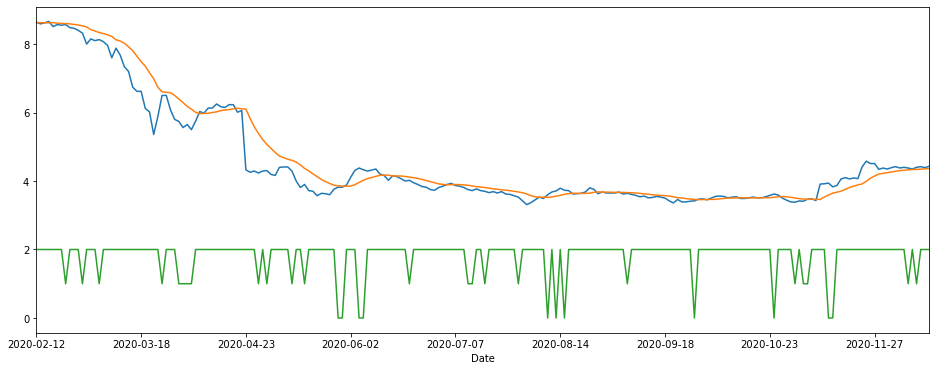

In [285]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

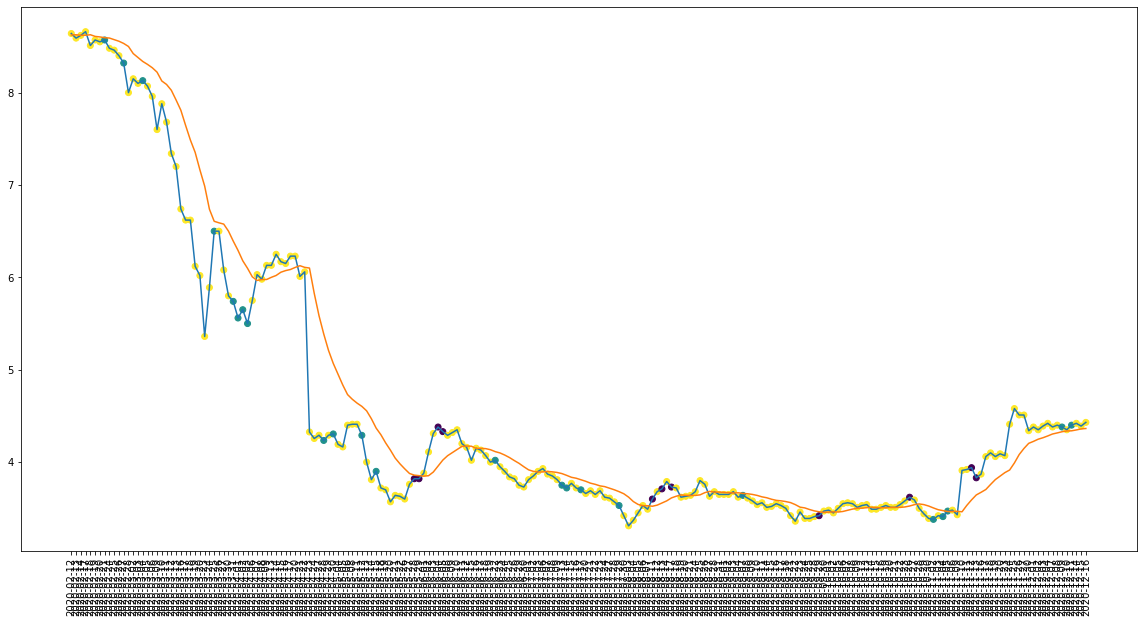

In [286]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

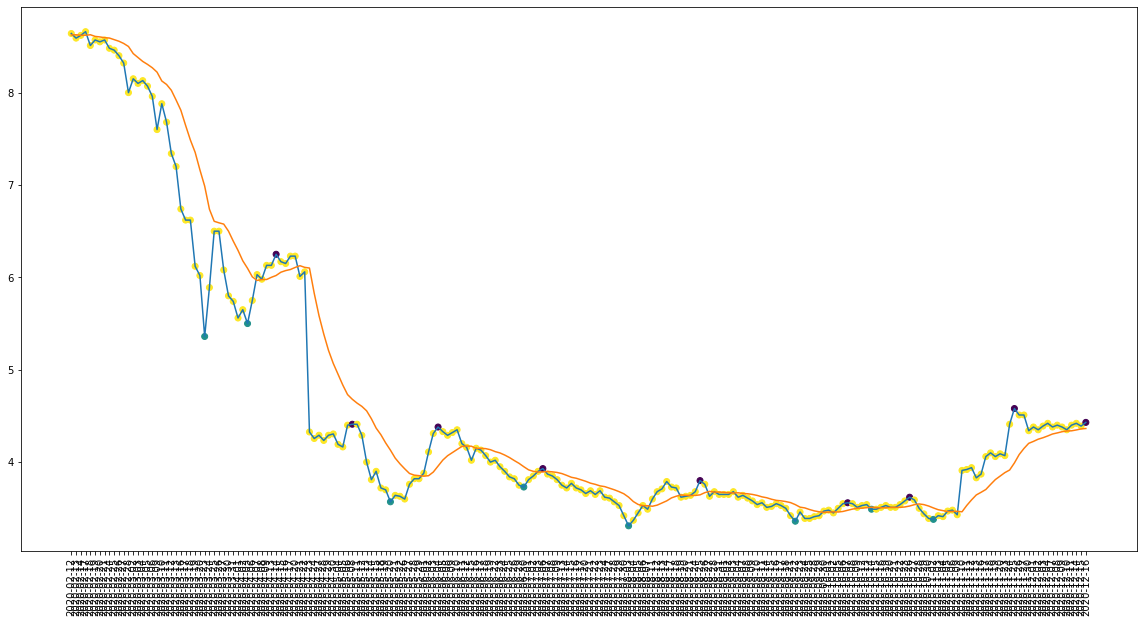

In [287]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [288]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 21
actual holds but predicted sell: 9
actual predicted holds: 168
Percentage buys correct: 25.0%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 84.84848484848484%
actual buys: 8
actual sells: 9
actual holds: 198


In [289]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 43.47826086956522%
Percentage sells correct: 63.63636363636363%
Percentage holds correct: 85.55555555555556%


In [290]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.569999694824219
Shares owned at the moment: 1163
Cash capital at the moment: $5.681353395460974


Stop Loss Activated!

Share price: $8.319999694824219
Shares owned at the moment: 0
Cash capital at the moment: $9655.231559452055


Share price: $8.319999694824219
Shares owned at the moment: 1157
Cash capital at the moment: $2.5197535114275524


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9233.065753511428


Share price: $8.130000114440918
Shares owned at the moment: 1132
Cash capital at the moment: $4.596933608054314


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $8584.138025948998


Share price: $6.5
Shares owned at the moment: 1317
Cash capital at the moment: $0.09665094899719406


Stop Loss Activated!

Share price: $6.079999923706055
Shares owned at the moment: 0
Cash capital at the moment: $7985.436310746189


Share price: $5.739999771118164
Share

In [291]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


### OCBC Bank

In [156]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


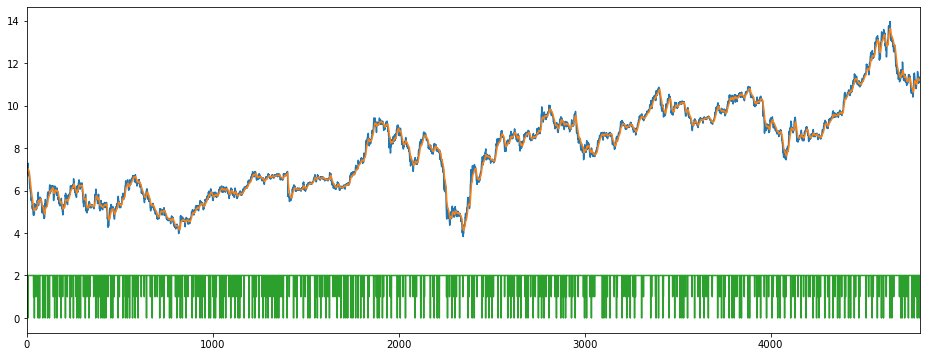

In [157]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [158]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0

In [159]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [160]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [161]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [162]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [163]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4784, 64, 64, 1)

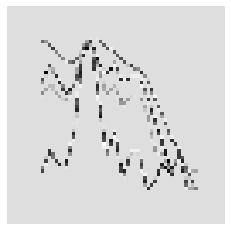

In [164]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [165]:
y[0]

2.0

In [166]:
X = X/255

In [167]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [168]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [169]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [211]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [212]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
# d_class_weights[0] = 9
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.2481060606060606, 1: 7.923395445134576, 2: 0.3655205348615091}
Epoch 1/200
30/30 [==============================] - 2s 70ms/step - loss: 0.2439 - accuracy: 0.2621 - mse: 1.6416 - weighted_accuracy: 0.3292 - weighted_mse: 1.6474 - val_loss: 0.2205 - val_accuracy: 0.0418 - val_mse: 0.9550 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.9550
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2139 - accuracy: 0.2096 - mse: 1.1751 - weighted_accuracy: 0.3210 - weighted_mse: 1.1458 - val_loss: 0.2241 - val_accuracy: 0.0439 - val_mse: 1.0389 - val_weighted_accuracy: 0.0439 - val_weighted_mse: 1.0389
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2062 - accuracy: 0.2652 - mse: 1.1814 - weighted_accuracy: 0.3479 - weighted_mse: 1.1496 - val_loss: 0.2009 - val_accuracy: 0.0418 - val_mse: 0.9917 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.9917
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2040 -

30/30 [==============================] - 0s 9ms/step - loss: 0.1982 - accuracy: 0.2522 - mse: 1.1859 - weighted_accuracy: 0.3768 - weighted_mse: 1.1750 - val_loss: 0.1953 - val_accuracy: 0.0554 - val_mse: 1.0720 - val_weighted_accuracy: 0.0554 - val_weighted_mse: 1.0720
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1950 - accuracy: 0.2378 - mse: 1.1988 - weighted_accuracy: 0.4238 - weighted_mse: 1.1773 - val_loss: 0.1967 - val_accuracy: 0.0564 - val_mse: 0.9552 - val_weighted_accuracy: 0.0564 - val_weighted_mse: 0.9552
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1940 - accuracy: 0.2299 - mse: 1.1786 - weighted_accuracy: 0.4362 - weighted_mse: 1.1793 - val_loss: 0.1989 - val_accuracy: 0.0596 - val_mse: 1.1192 - val_weighted_accuracy: 0.0596 - val_weighted_mse: 1.1192
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1968 - accuracy: 0.2459 - mse: 1.1926 - weighted_accuracy: 0.4232 - weighted_mse: 1.1

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1766 - accuracy: 0.1623 - mse: 1.2754 - weighted_accuracy: 0.5120 - weighted_mse: 1.2467 - val_loss: 0.2026 - val_accuracy: 0.0961 - val_mse: 1.0056 - val_weighted_accuracy: 0.0961 - val_weighted_mse: 1.0056
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1748 - accuracy: 0.1683 - mse: 1.3182 - weighted_accuracy: 0.5481 - weighted_mse: 1.2642 - val_loss: 0.2008 - val_accuracy: 0.0930 - val_mse: 1.0494 - val_weighted_accuracy: 0.0930 - val_weighted_mse: 1.0494
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1742 - accuracy: 0.1649 - mse: 1.3262 - weighted_accuracy: 0.5210 - weighted_mse: 1.2958 - val_loss: 0.1986 - val_accuracy: 0.1108 - val_mse: 1.1335 - val_weighted_accuracy: 0.1108 - val_weighted_mse: 1.1335
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1710 - accuracy: 0.1748 - mse: 1.3586 - weighted_accuracy: 0.5572 - weig

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1533 - accuracy: 0.2171 - mse: 1.5009 - weighted_accuracy: 0.6132 - weighted_mse: 1.4834 - val_loss: 0.1988 - val_accuracy: 0.1891 - val_mse: 1.2726 - val_weighted_accuracy: 0.1891 - val_weighted_mse: 1.2726
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1539 - accuracy: 0.2064 - mse: 1.4785 - weighted_accuracy: 0.6075 - weighted_mse: 1.4537 - val_loss: 0.1979 - val_accuracy: 0.2006 - val_mse: 1.3618 - val_weighted_accuracy: 0.2006 - val_weighted_mse: 1.3618
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1529 - accuracy: 0.2114 - mse: 1.5086 - weighted_accuracy: 0.6014 - weighted_mse: 1.4820 - val_loss: 0.1981 - val_accuracy: 0.1923 - val_mse: 1.3847 - val_weighted_accuracy: 0.1923 - val_weighted_mse: 1.3847
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1544 - accuracy: 0.2059 - mse: 1.4726 - weighted_accuracy: 0.5996 - we

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1363 - accuracy: 0.3180 - mse: 1.7717 - weighted_accuracy: 0.6898 - weighted_mse: 1.9220 - val_loss: 0.1903 - val_accuracy: 0.3197 - val_mse: 1.5146 - val_weighted_accuracy: 0.3197 - val_weighted_mse: 1.5146
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1376 - accuracy: 0.3167 - mse: 1.7297 - weighted_accuracy: 0.6746 - weighted_mse: 1.8359 - val_loss: 0.1906 - val_accuracy: 0.3177 - val_mse: 1.5093 - val_weighted_accuracy: 0.3177 - val_weighted_mse: 1.5093
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1409 - accuracy: 0.3073 - mse: 1.7197 - weighted_accuracy: 0.6647 - weighted_mse: 1.8034 - val_loss: 0.1851 - val_accuracy: 0.3448 - val_mse: 1.5575 - val_weighted_accuracy: 0.3448 - val_weighted_mse: 1.5575
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1368 - accuracy: 0.3238 - mse: 1.7678 - weighted_accuracy: 0.6867 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1191 - accuracy: 0.4777 - mse: 2.1052 - weighted_accuracy: 0.7589 - weighted_mse: 2.4930 - val_loss: 0.1662 - val_accuracy: 0.5350 - val_mse: 1.8638 - val_weighted_accuracy: 0.5350 - val_weighted_mse: 1.8638
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1241 - accuracy: 0.4808 - mse: 2.1219 - weighted_accuracy: 0.7459 - weighted_mse: 2.4805 - val_loss: 0.1649 - val_accuracy: 0.5256 - val_mse: 1.7232 - val_weighted_accuracy: 0.5256 - val_weighted_mse: 1.7232
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1239 - accuracy: 0.4677 - mse: 2.0800 - weighted_accuracy: 0.7362 - weighted_mse: 2.4808 - val_loss: 0.1725 - val_accuracy: 0.5319 - val_mse: 1.8803 - val_weighted_accuracy: 0.5319 - val_weighted_mse: 1.8803
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1203 - accuracy: 0.4834 - mse: 2.1578 - weighted_accuracy: 0.7515 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1100 - accuracy: 0.5856 - mse: 2.5940 - weighted_accuracy: 0.7903 - weighted_mse: 3.4228 - val_loss: 0.1517 - val_accuracy: 0.6290 - val_mse: 2.1123 - val_weighted_accuracy: 0.6290 - val_weighted_mse: 2.1123
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1067 - accuracy: 0.5804 - mse: 2.6170 - weighted_accuracy: 0.7934 - weighted_mse: 3.4455 - val_loss: 0.1543 - val_accuracy: 0.6102 - val_mse: 2.0065 - val_weighted_accuracy: 0.6102 - val_weighted_mse: 2.0065
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1075 - accuracy: 0.6109 - mse: 2.6133 - weighted_accuracy: 0.8100 - weighted_mse: 3.3227 - val_loss: 0.1441 - val_accuracy: 0.6708 - val_mse: 2.1399 - val_weighted_accuracy: 0.6708 - val_weighted_mse: 2.1399
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1064 - accuracy: 0.6114 - mse: 2.5702 - weighted_accuracy: 0.8110 - 

In [213]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12879791855812073
Test accuracy: 0.7283176779747009


In [214]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.8929663  -1.1161143  -0.00958286]
 [-1.320334   -1.5580766  -0.24650328]
 [-0.75931495 -2.2535317  -0.2791497 ]
 ...
 [-1.3454062  -1.2713696  -0.03024302]
 [-1.7867483  -0.85457146 -0.34014648]
 [ 0.26280797 -3.7894673  -0.90507764]]


Counter({2: 757, 0: 132, 1: 68})

In [215]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 873, 1: 40, 0: 44})

In [216]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 957
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 38
actual holds but predicted buy: 61
actual holds but predicted sell: 126
actual predicted holds: 686
Percentage buys correct: 15.0%
Percentage sells correct: 11.363636363636363%
Percentage holds correct: 78.57961053837343%
actual buys: 40
actual sells: 44
actual holds: 873


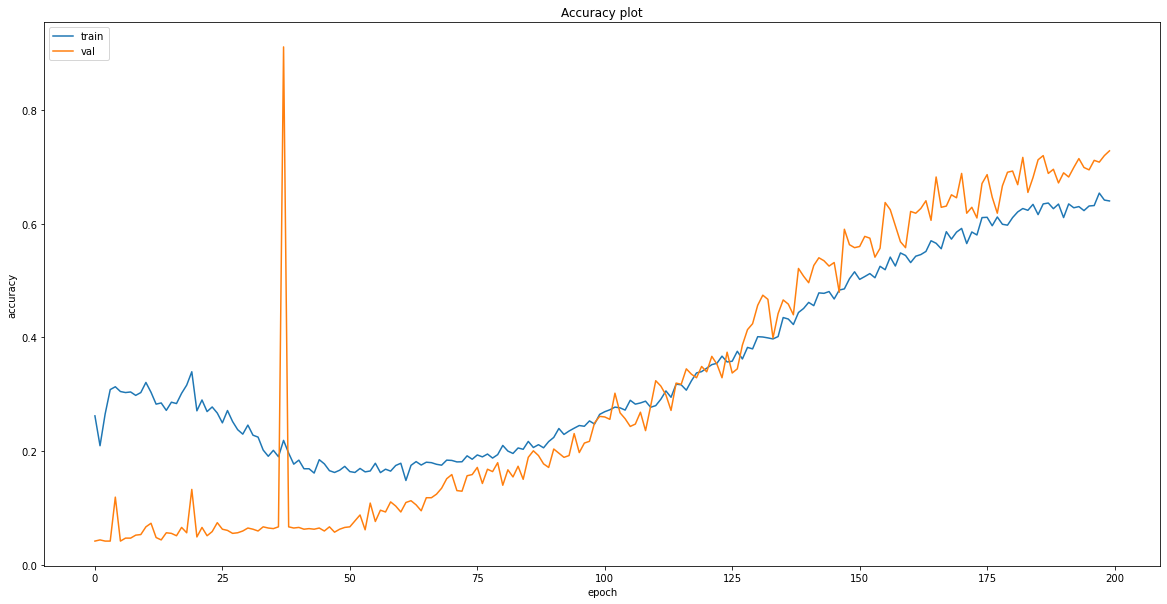

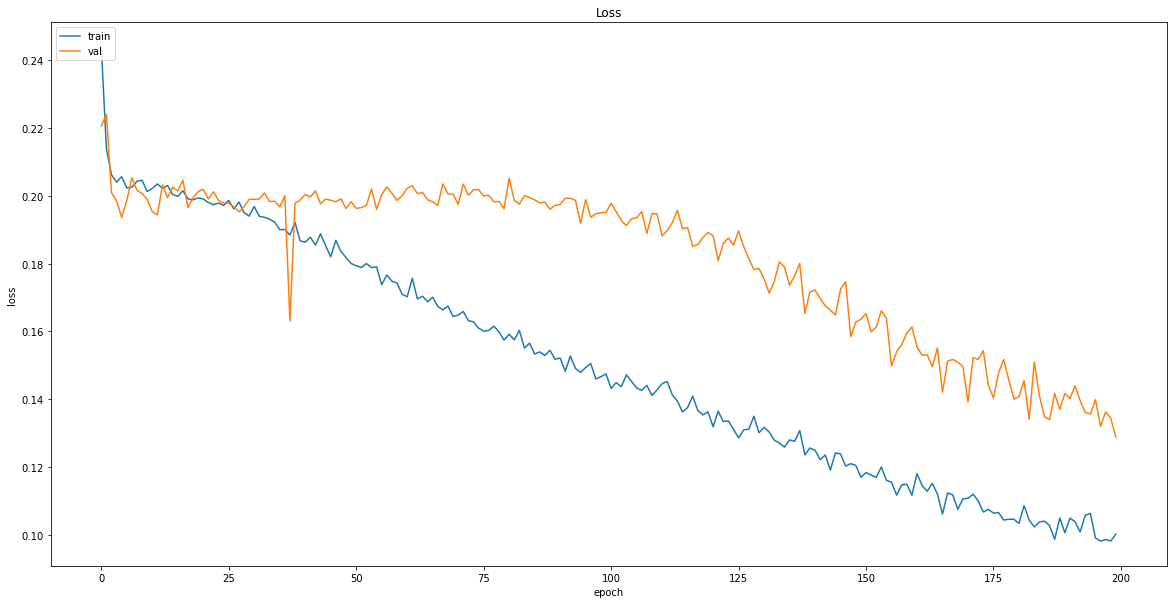

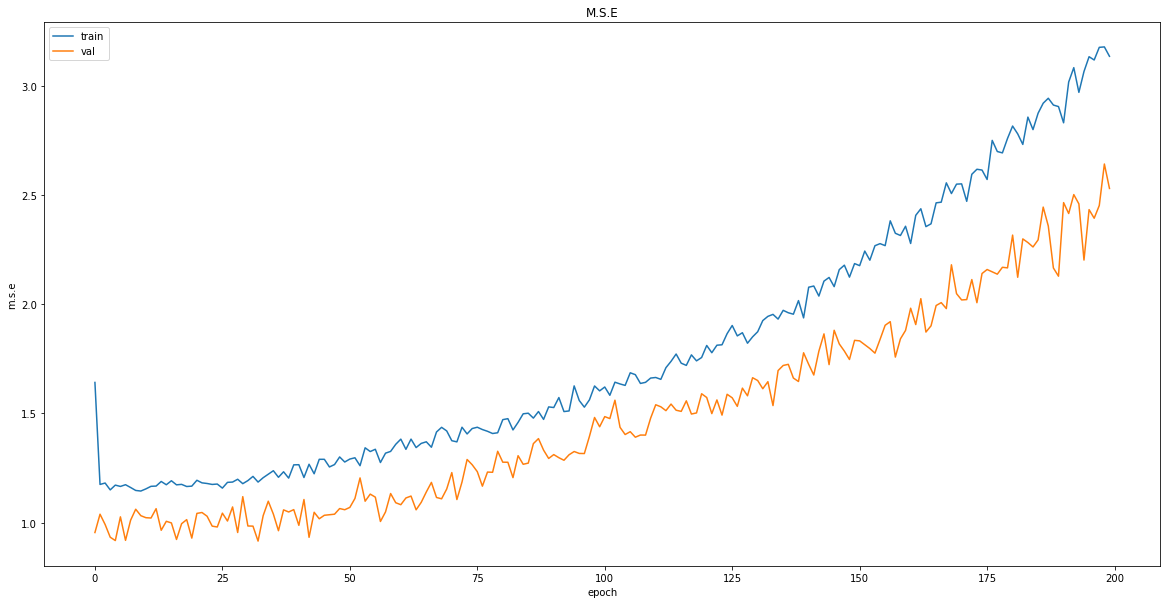

In [217]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [218]:
# Save model
model.save("models/{}".format('OCBC_image_cnn_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/OCBC_image_cnn_buy_hold_sell_20.model\assets


### Test Performance

#### Non-Recession

In [219]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


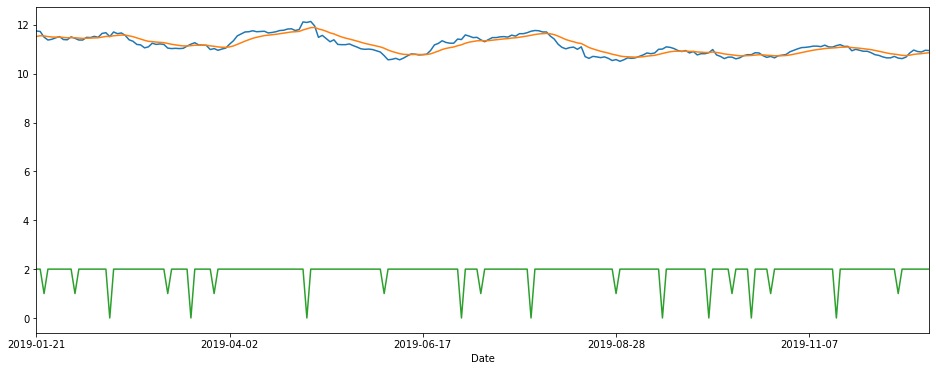

In [220]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [221]:
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])

In [222]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1
        
# willr_data = np.array(willr_data)
# price_data = np.array(price_data)
# ema_data = np.array(ema_data)
# obv_data = np.array(obv_data)

In [223]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [224]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [225]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [226]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [227]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1287 - accuracy: 0.7156 - mean_squared_error: 2.6490 - weighted_accuracy: 0.7156 - weighted_mean_squared_error: 2.6490
Test loss: 0.1287304311990738
Test accuracy: 0.7155963182449341


In [228]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 164, 0: 44, 1: 10})

In [229]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [230]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-230-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-230-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-230-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        11.53  11.457507 -67.857228  17615658.0     2.0   
2019-02-12        11.49  11.468659 -43.902530  20832858.0     2.0   
2019-02-13        11.65  11.471942 -42.424356  17325458.0     2.0   
2019-02-14        11.68  11.499336 -10.256417  22091358.0     2.0   
2019-02-15        11.52  11.527130  -5.714153  24228358.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            0       2  
2019-02-15            2       2

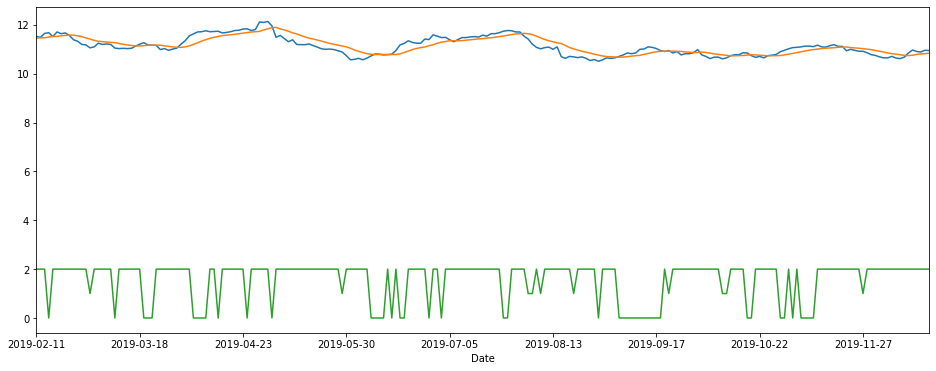

In [231]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

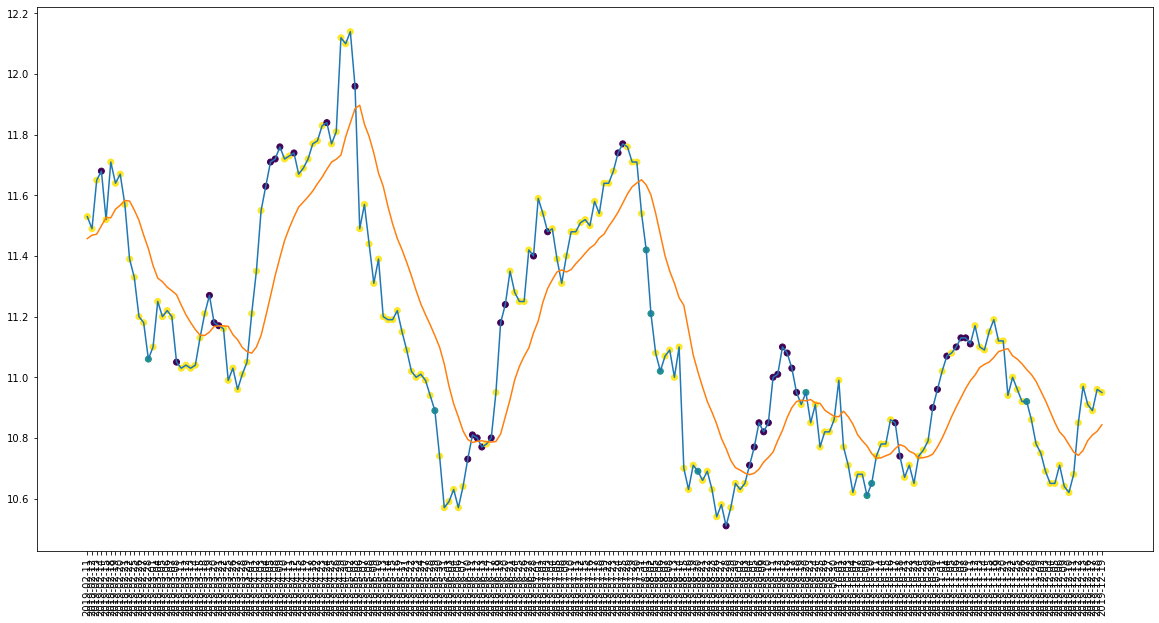

In [232]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

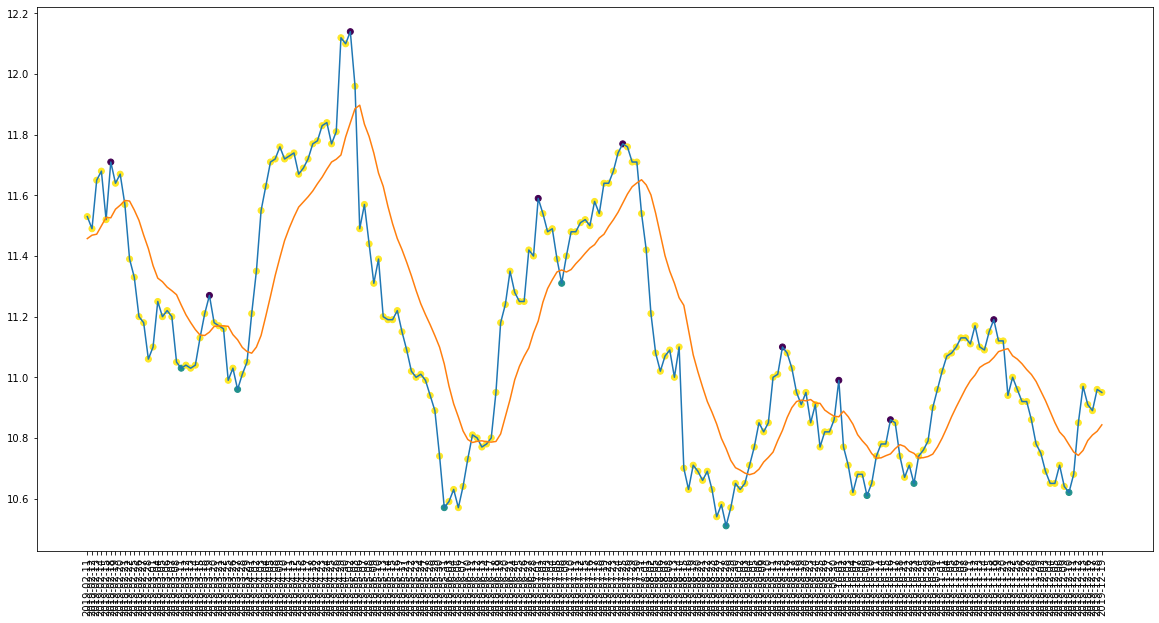

In [233]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [234]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 9
actual holds but predicted sell: 40
actual predicted holds: 152
Percentage buys correct: 12.5%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 75.62189054726367%
actual buys: 8
actual sells: 9
actual holds: 201


In [235]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 40.0%
Percentage sells correct: 50.0%
Percentage holds correct: 86.50306748466258%


In [236]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.0600004196167
Shares owned at the moment: 901
Cash capital at the moment: $7.535705885647985


Price increase from previously bought: 5.5866673507643405%
Share price: $11.710000038146973
Shares owned at the moment: 0
Cash capital at the moment: $10529.23128766155


Share price: $10.890000343322754
Shares owned at the moment: 964
Cash capital at the moment: $2.4015657882664527


Stop Loss Activated!

Share price: $10.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10163.860202407835


Share price: $11.420000076293945
Shares owned at the moment: 887
Cash capital at the moment: $6.463899549005873


Stop Loss Activated!

Share price: $11.079999923706056
Shares owned at the moment: 0
Cash capital at the moment: $9807.396942062378


Share price: $11.020000457763672
Shares owned at the moment: 887
Cash capital at the moment: $5.775999909401435


Stop Loss Activated!

Share price: $10.699999809265137
Shares owned at the moment: 0
Cash capital at the m

In [237]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


#### Recession

In [238]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


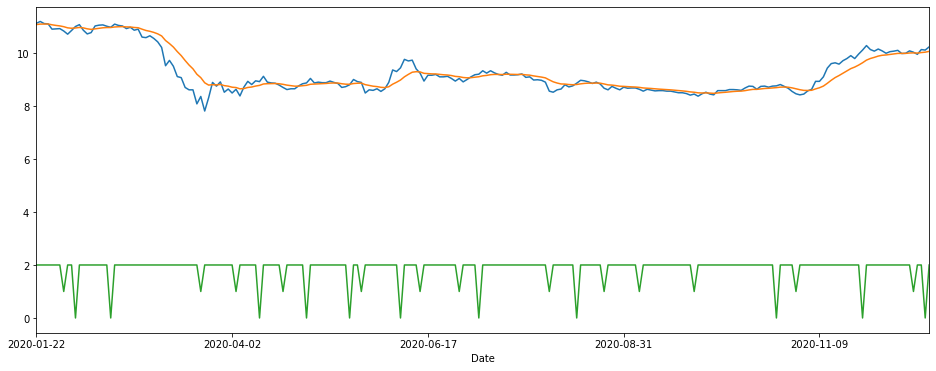

In [239]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [240]:
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-12-16        10.97  10.791319 -18.367351  53474942.0     2.0
2019-12-17        10.91  10.809578 -30.612316  49577542.0     2.0
2019-12-18        10.89  10.821951 -34.693842  45681342.0     2.0
2019-12-19        10.96  10.843189 -20.408211  50188142.0     2.0
2019-12-20        10.95  10.859621 -22.449071  47197442.0     2.0

In [241]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [242]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [243]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [244]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [245]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1321 - accuracy: 0.7535 - mean_squared_error: 2.5298 - weighted_accuracy: 0.7535 - weighted_mean_squared_error: 2.5298
Test loss: 0.13208629190921783
Test accuracy: 0.7534883618354797


In [246]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 0: 22, 1: 13})

In [247]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [248]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-248-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-248-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-248-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-12        11.02  10.890637 -80.357049  13333200.0     2.0   
2020-02-13        11.05  10.910539 -32.075322  21593100.0     2.0   
2020-02-14        11.06  10.931995 -15.217324  25962500.0     2.0   
2020-02-17        11.01  10.951688 -13.043361  29610200.0     2.0   
2020-02-18        10.97  10.960659 -23.912967  27996300.0     2.0   

            predictions  actual  
Date                             
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            0       2  
2020-02-18            0       2

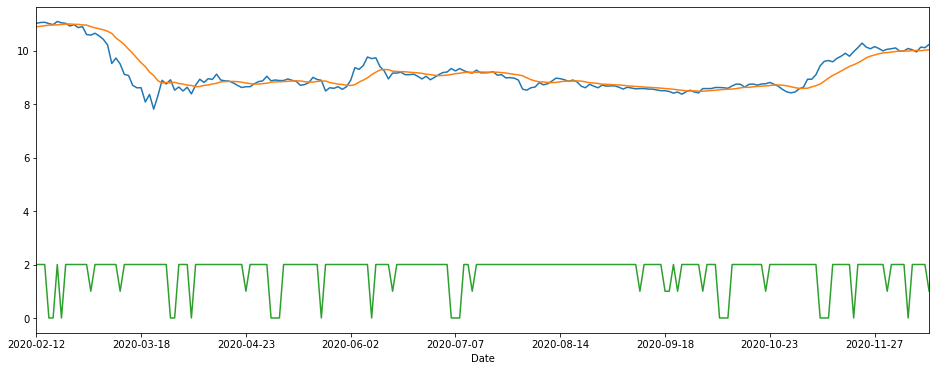

In [249]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

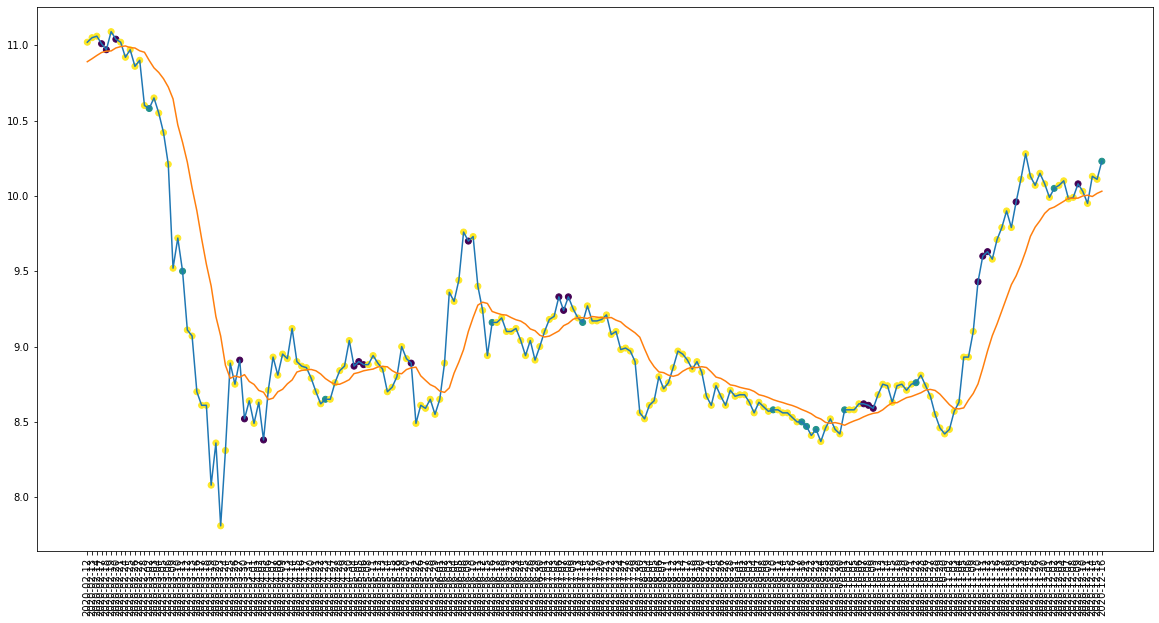

In [250]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

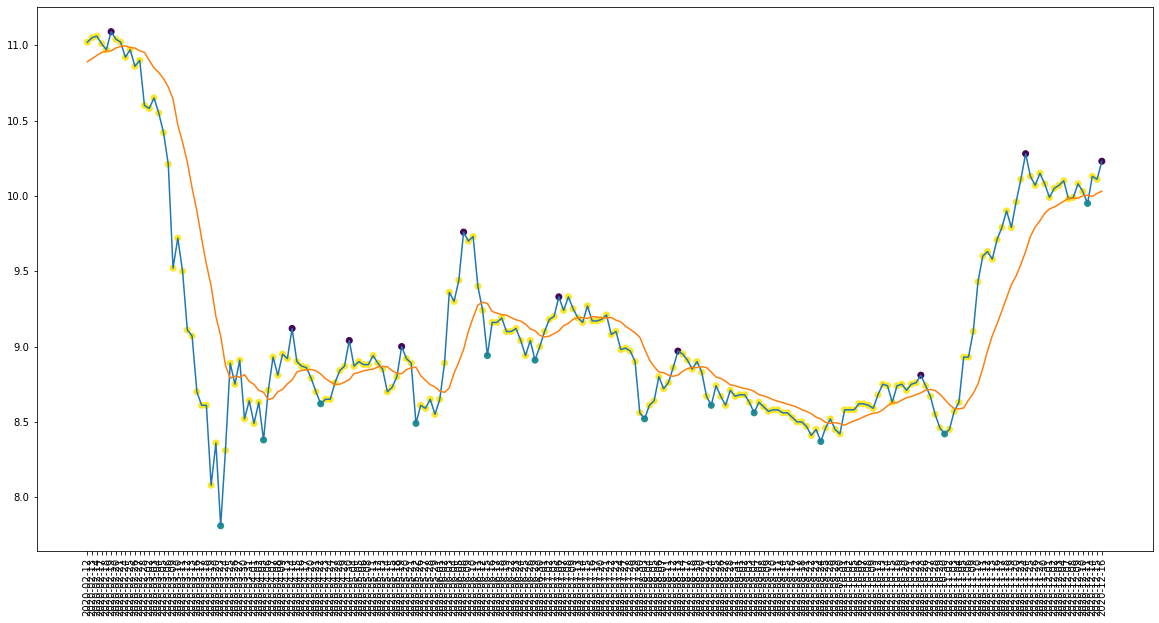

In [251]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [252]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 12
actual holds but predicted sell: 20
actual predicted holds: 161
Percentage buys correct: 0.0%
Percentage sells correct: 10.0%
Percentage holds correct: 83.41968911917098%
actual buys: 12
actual sells: 10
actual holds: 193


In [253]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 46.15384615384615%
Percentage sells correct: 59.09090909090909%
Percentage holds correct: 86.59217877094972%


In [254]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.579999923706056
Shares owned at the moment: 942
Cash capital at the moment: $6.232582066533723


Stop Loss Activated!

Share price: $10.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9597.603612902161


Share price: $9.5
Shares owned at the moment: 1007
Cash capital at the moment: $4.795737902160909


Stop Loss Activated!

Share price: $9.109999656677246
Shares owned at the moment: 0
Cash capital at the moment: $9153.337525626894


Share price: $8.649999618530272
Shares owned at the moment: 1055
Cash capital at the moment: $2.492116684195935


Price increase from previously bought: 11.831195277039575%
Share price: $9.699999809265137
Shares owned at the moment: 0
Cash capital at the moment: $10207.849791012284


Share price: $9.15999984741211
Shares owned at the moment: 1111
Cash capital at the moment: $3.1038710036245902


Stop Loss Activated!

Share price: $8.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $9863.81

In [255]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


## CNOOC Limited

In [634]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


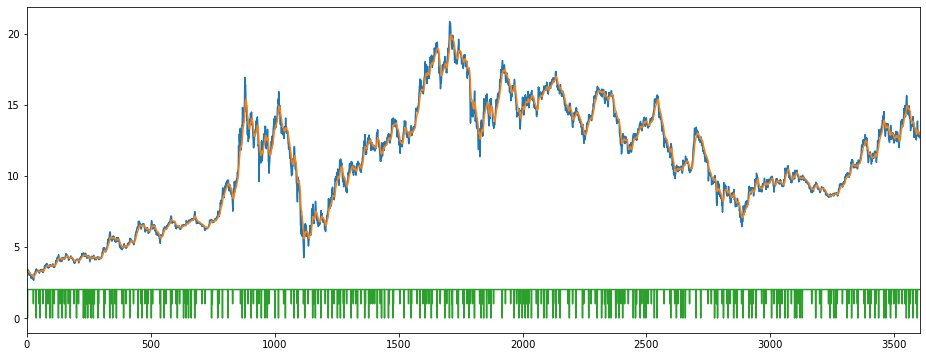

In [635]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [636]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0

In [637]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [638]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [639]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [640]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3585, 64, 64, 1)

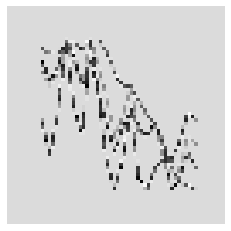

In [641]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [642]:
X = X/255

In [643]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [644]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [645]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [1082]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [1083]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
# d_class_weights[0] = 7
# d_class_weights[1] = 7
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.264367816091954, 1: 7.30635838150289, 2: 0.3669085631349782}
Epoch 1/200
30/30 [==============================] - 3s 108ms/step - loss: 0.2493 - accuracy: 0.4773 - mse: 1.5588 - weighted_accuracy: 0.3395 - weighted_mse: 1.6885 - val_loss: 0.1890 - val_accuracy: 0.8850 - val_mse: 0.8168 - val_weighted_accuracy: 0.8850 - val_weighted_mse: 0.8168
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2087 - accuracy: 0.4818 - mse: 1.1359 - weighted_accuracy: 0.3375 - weighted_mse: 1.1632 - val_loss: 0.1801 - val_accuracy: 0.8945 - val_mse: 0.9283 - val_weighted_accuracy: 0.8945 - val_weighted_mse: 0.9283
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2110 - accuracy: 0.3476 - mse: 1.1733 - weighted_accuracy: 0.3175 - weighted_mse: 1.1616 - val_loss: 0.1897 - val_accuracy: 0.6593 - val_mse: 1.0470 - val_weighted_accuracy: 0.6593 - val_weighted_mse: 1.0470
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2072 -

30/30 [==============================] - 0s 9ms/step - loss: 0.1951 - accuracy: 0.3080 - mse: 1.1820 - weighted_accuracy: 0.4231 - weighted_mse: 1.1724 - val_loss: 0.1899 - val_accuracy: 0.3713 - val_mse: 1.0197 - val_weighted_accuracy: 0.3713 - val_weighted_mse: 1.0197
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1958 - accuracy: 0.3209 - mse: 1.1733 - weighted_accuracy: 0.4151 - weighted_mse: 1.1764 - val_loss: 0.2010 - val_accuracy: 0.1002 - val_mse: 0.9862 - val_weighted_accuracy: 0.1002 - val_weighted_mse: 0.9862
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1984 - accuracy: 0.2864 - mse: 1.1896 - weighted_accuracy: 0.3914 - weighted_mse: 1.1635 - val_loss: 0.1929 - val_accuracy: 0.3196 - val_mse: 1.0224 - val_weighted_accuracy: 0.3196 - val_weighted_mse: 1.0224
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1946 - accuracy: 0.3521 - mse: 1.1970 - weighted_accuracy: 0.4319 - weighted_mse: 1.1

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1730 - accuracy: 0.2360 - mse: 1.2563 - weighted_accuracy: 0.5465 - weighted_mse: 1.2523 - val_loss: 0.1964 - val_accuracy: 0.2426 - val_mse: 0.9981 - val_weighted_accuracy: 0.2426 - val_weighted_mse: 0.9981
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1738 - accuracy: 0.2197 - mse: 1.2419 - weighted_accuracy: 0.5368 - weighted_mse: 1.2189 - val_loss: 0.1915 - val_accuracy: 0.2774 - val_mse: 1.1281 - val_weighted_accuracy: 0.2774 - val_weighted_mse: 1.1281
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1703 - accuracy: 0.2297 - mse: 1.2900 - weighted_accuracy: 0.5497 - weighted_mse: 1.2738 - val_loss: 0.1967 - val_accuracy: 0.2226 - val_mse: 1.0298 - val_weighted_accuracy: 0.2226 - val_weighted_mse: 1.0298
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1704 - accuracy: 0.2497 - mse: 1.2863 - weighted_accuracy: 0.5552 - wei

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1466 - accuracy: 0.3223 - mse: 1.5139 - weighted_accuracy: 0.6620 - weighted_mse: 1.5227 - val_loss: 0.1850 - val_accuracy: 0.3555 - val_mse: 1.3589 - val_weighted_accuracy: 0.3555 - val_weighted_mse: 1.3589
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1442 - accuracy: 0.3220 - mse: 1.5787 - weighted_accuracy: 0.6837 - weighted_mse: 1.5894 - val_loss: 0.1830 - val_accuracy: 0.3797 - val_mse: 1.2988 - val_weighted_accuracy: 0.3797 - val_weighted_mse: 1.2988
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1473 - accuracy: 0.3009 - mse: 1.4876 - weighted_accuracy: 0.6450 - weighted_mse: 1.5154 - val_loss: 0.1886 - val_accuracy: 0.3544 - val_mse: 1.3598 - val_weighted_accuracy: 0.3544 - val_weighted_mse: 1.3598
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1505 - accuracy: 0.3180 - mse: 1.4865 - weighted_accuracy: 0.6202 - w

Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1331 - accuracy: 0.4016 - mse: 1.6996 - weighted_accuracy: 0.6893 - weighted_mse: 1.8185 - val_loss: 0.1744 - val_accuracy: 0.4778 - val_mse: 1.4997 - val_weighted_accuracy: 0.4778 - val_weighted_mse: 1.4997
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1281 - accuracy: 0.4391 - mse: 1.7482 - weighted_accuracy: 0.7286 - weighted_mse: 1.9111 - val_loss: 0.1689 - val_accuracy: 0.5169 - val_mse: 1.4890 - val_weighted_accuracy: 0.5169 - val_weighted_mse: 1.4890
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1290 - accuracy: 0.4185 - mse: 1.7547 - weighted_accuracy: 0.7156 - weighted_mse: 1.9109 - val_loss: 0.1704 - val_accuracy: 0.5179 - val_mse: 1.5353 - val_weighted_accuracy: 0.5179 - val_weighted_mse: 1.5353
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1252 - accuracy: 0.4293 - mse: 1.7687 - weighted_accuracy: 0.7250

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1129 - accuracy: 0.5427 - mse: 2.0284 - weighted_accuracy: 0.7666 - weighted_mse: 2.4682 - val_loss: 0.1566 - val_accuracy: 0.6044 - val_mse: 1.7163 - val_weighted_accuracy: 0.6044 - val_weighted_mse: 1.7163
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1083 - accuracy: 0.5588 - mse: 2.0829 - weighted_accuracy: 0.7907 - weighted_mse: 2.6607 - val_loss: 0.1533 - val_accuracy: 0.6329 - val_mse: 1.8261 - val_weighted_accuracy: 0.6329 - val_weighted_mse: 1.8261
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1111 - accuracy: 0.5551 - mse: 2.1332 - weighted_accuracy: 0.7675 - weighted_mse: 2.6462 - val_loss: 0.1546 - val_accuracy: 0.6319 - val_mse: 1.8213 - val_weighted_accuracy: 0.6319 - val_weighted_mse: 1.8213
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1111 - accuracy: 0.5651 - mse: 2.1340 - weighted_accuracy: 0.7749 -

Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0935 - accuracy: 0.6514 - mse: 2.5462 - weighted_accuracy: 0.8210 - weighted_mse: 3.6995 - val_loss: 0.1310 - val_accuracy: 0.7416 - val_mse: 2.0144 - val_weighted_accuracy: 0.7416 - val_weighted_mse: 2.0144
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0922 - accuracy: 0.6635 - mse: 2.5248 - weighted_accuracy: 0.8255 - weighted_mse: 3.6752 - val_loss: 0.1302 - val_accuracy: 0.7489 - val_mse: 2.0301 - val_weighted_accuracy: 0.7489 - val_weighted_mse: 2.0301
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0940 - accuracy: 0.6493 - mse: 2.5179 - weighted_accuracy: 0.8184 - weighted_mse: 3.7369 - val_loss: 0.1341 - val_accuracy: 0.7373 - val_mse: 2.0922 - val_weighted_accuracy: 0.7373 - val_weighted_mse: 2.0922
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0935 - accuracy: 0.6456 - mse: 2.5654 - weighted_accuracy: 0.8098

In [1084]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11757425218820572
Test accuracy: 0.7869198322296143


In [1085]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.8716288  -1.0596608   0.06055638]
 [-1.5079128  -1.8072988   0.10673919]
 [-1.0501498  -1.9541506  -0.04064286]
 ...
 [-0.9339086  -1.9992746  -0.15261336]
 [-1.4621885  -1.8019289   0.09067065]
 [-1.4834466  -1.1829343   0.03124752]]


Counter({2: 806, 1: 88, 0: 54})

In [1086]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 861, 0: 43, 1: 44})

In [1087]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 948
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 36
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 37
actual holds but predicted buy: 79
actual holds but predicted sell: 49
actual predicted holds: 733
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 11.627906976744185%
Percentage holds correct: 85.1335656213705%
actual buys: 44
actual sells: 43
actual holds: 861


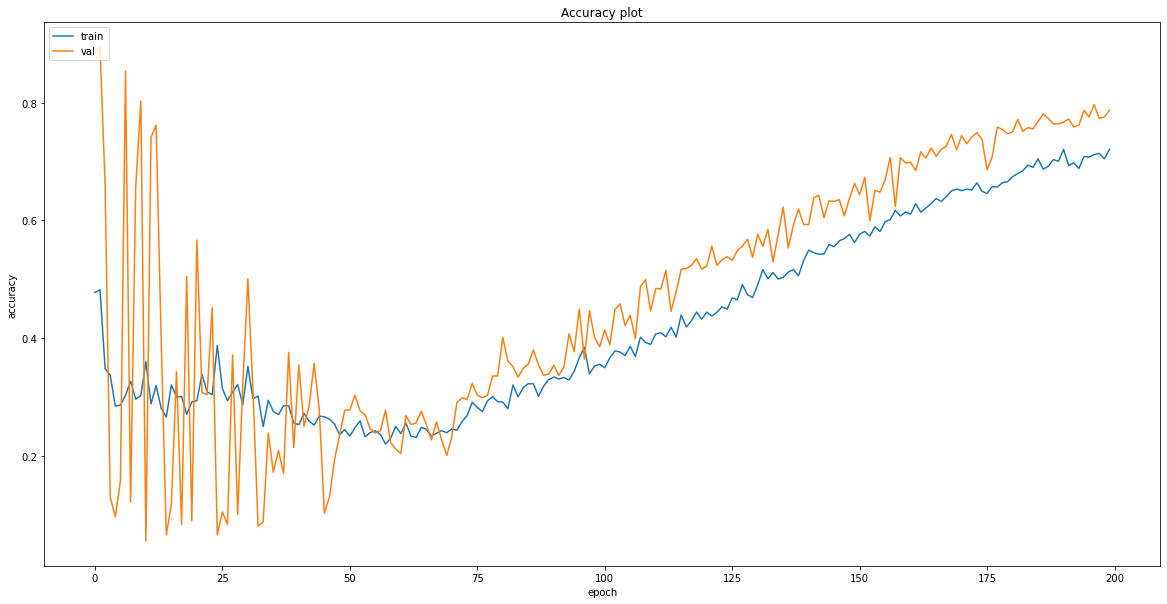

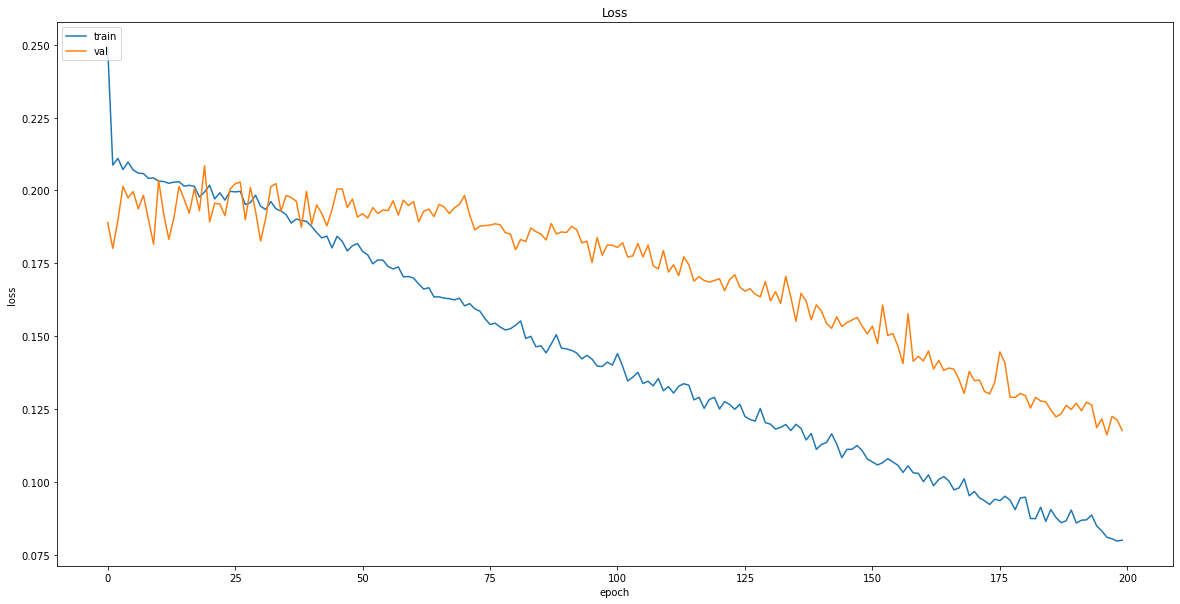

In [1088]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [1089]:
# Save model
model.save("models/{}".format('cnooc_image_cnn_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/cnooc_image_cnn_buy_hold_sell_20.model\assets


### Test Performance

#### Non-Recession

In [1090]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-12-12        12.74  13.032944 -77.906974  9.460210e+09     2.0
2018-12-13        12.74  12.987876 -77.906974  9.460210e+09     2.0
2018-12-14        13.06  12.998972 -59.302288  9.506982e+09     2.0
2018-12-17        12.80  12.968361 -78.048748  9.447852e+09     2.0
2018-12-18        12.68  12.923998 -95.890382  9.410332e+09     2.0

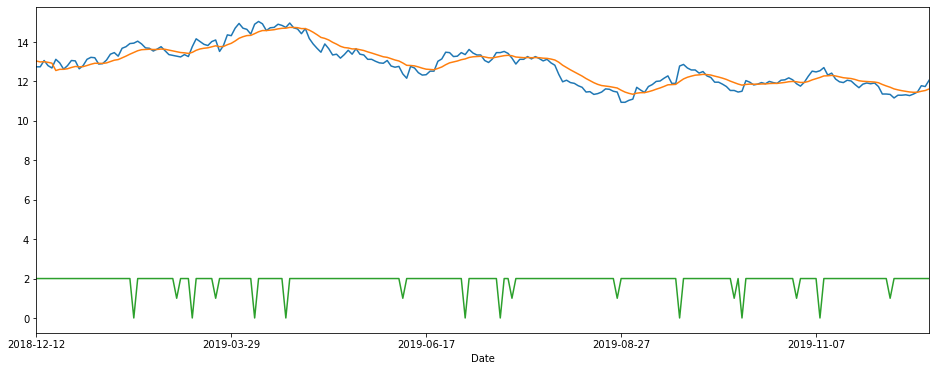

In [1091]:
#%matplotlib notebook
df2['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df2['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df2['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [1092]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [1093]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [1094]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [1095]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [1096]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1245 - accuracy: 0.7678 - mean_squared_error: 2.6428 - weighted_accuracy: 0.7678 - weighted_mean_squared_error: 2.6428
Test loss: 0.12446728348731995
Test accuracy: 0.7677724957466125


In [1097]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 172, 0: 15, 1: 24})

In [1098]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [1099]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-1099-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-1099-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-1099-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-14        13.46  13.005887  -9.090899  594167146.0     2.0   
2019-02-15        13.28  13.075751  -2.222168  636062191.0     2.0   
2019-02-18        13.68  13.107174 -22.222210  601994876.0     2.0   
2019-02-19        13.76  13.195301 -15.384598  654106730.0     2.0   
2019-02-20        13.92  13.282178  -9.230759  687559434.0     2.0   

            predictions  actual  
Date                             
2019-02-14            2       2  
2019-02-15            2       2  
2019-02-18            2       2  
2019-02-19            2       2  
2019-02-20            2       2

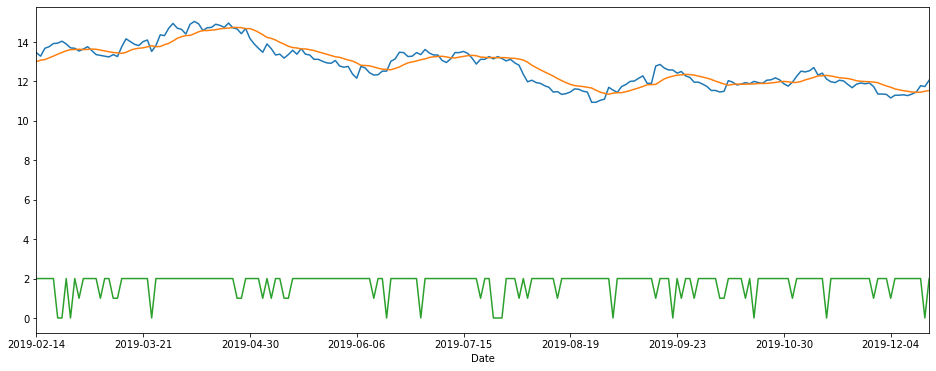

In [1100]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

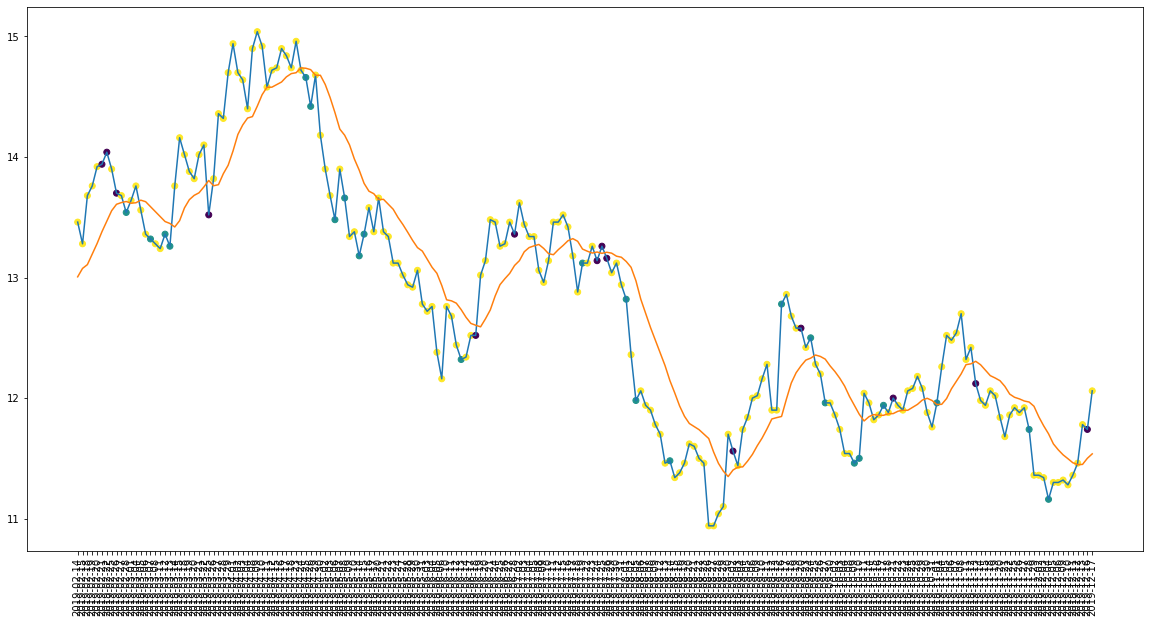

In [1101]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

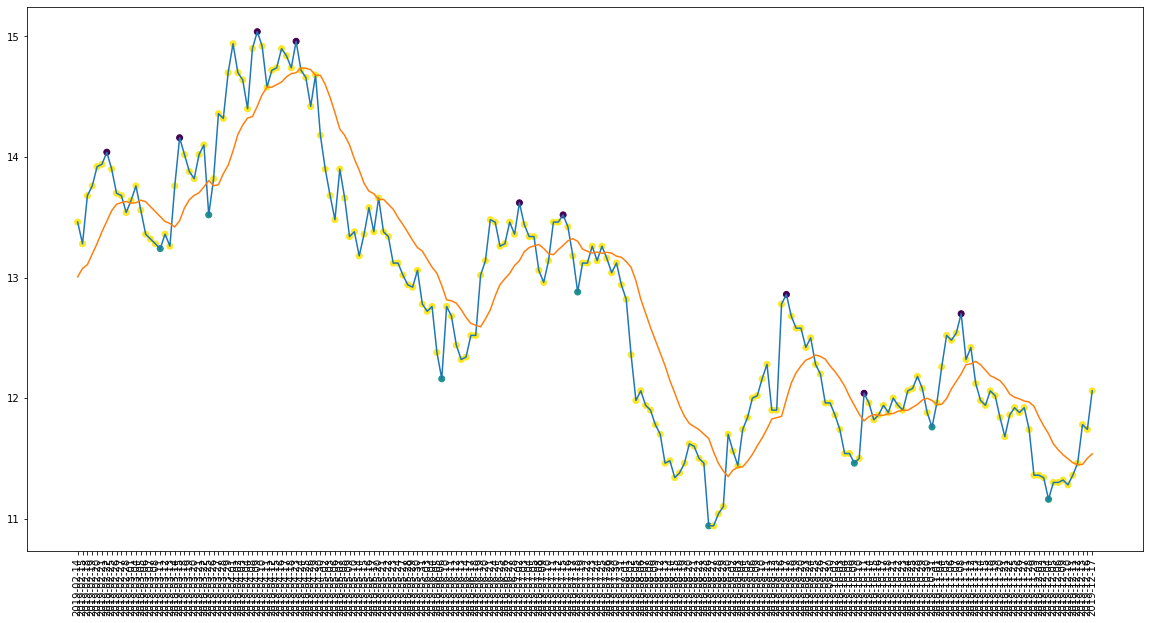

In [1102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [1103]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 22
actual holds but predicted sell: 13
actual predicted holds: 159
Percentage buys correct: 25.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 81.95876288659794%
actual buys: 8
actual sells: 9
actual holds: 194


In [1104]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 57.142857142857146%
Percentage holds correct: 81.97674418604652%


In [1105]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.539999961853027
Shares owned at the moment: 736
Cash capital at the moment: $7.155068153380853


Stop Loss Activated!

Share price: $13.119999885559082
Shares owned at the moment: 0
Cash capital at the moment: $9636.920104156494


Share price: $12.31999969482422
Shares owned at the moment: 780
Cash capital at the moment: $0.8939428482026415


Price increase from previously bought: 8.144161895814218%
Share price: $13.359999656677244
Shares owned at the moment: 0
Cash capital at the moment: $10393.03647579288


Share price: $13.119999885559082
Shares owned at the moment: 789
Cash capital at the moment: $12.889446335071625


Stop Loss Activated!

Share price: $12.359999656677244
Shares owned at the moment: 0
Cash capital at the moment: $9738.111066198342


Share price: $11.979999542236328
Shares owned at the moment: 810
Cash capital at the moment: $7.625988006584521


Stop Loss Activated!

Share price: $11.460000038146973
Shares owned at the moment: 0
Cash capital at the 

In [1106]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [1067]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-12-12        11.36  11.447620 -75.000025 -214227973.0     2.0
2019-12-13        11.46  11.449525 -64.583319 -167306085.0     2.0
2019-12-16        11.78  11.500367 -31.250019  -82839244.0     2.0
2019-12-17        11.74  11.537234 -31.111168 -127828316.0     2.0
2019-12-18        12.06  11.617659  -5.999947  -67007162.0     2.0

In [1068]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [1069]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [1070]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [1071]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [1072]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1264 - accuracy: 0.7840 - mean_squared_error: 2.9409 - weighted_accuracy: 0.7840 - weighted_mean_squared_error: 2.9409
Test loss: 0.12643389403820038
Test accuracy: 0.7840375304222107


In [1073]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 0: 12, 1: 18})

In [1074]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [1075]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-1075-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-1075-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-1075-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2020-02-13        12.34  12.385912 -50.526328  113135355.0     2.0   
2020-02-14        12.34  12.378849 -50.588221   60757697.0     2.0   
2020-02-17        12.26  12.372872 -46.153851   60757697.0     2.0   
2020-02-18        12.00  12.355507 -38.709648    5146960.0     2.0   
2020-02-19        12.08  12.300814 -59.677412  -52626865.0     2.0   

            predictions  actual  
Date                             
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            2       2  
2020-02-18            2       2  
2020-02-19            2       2

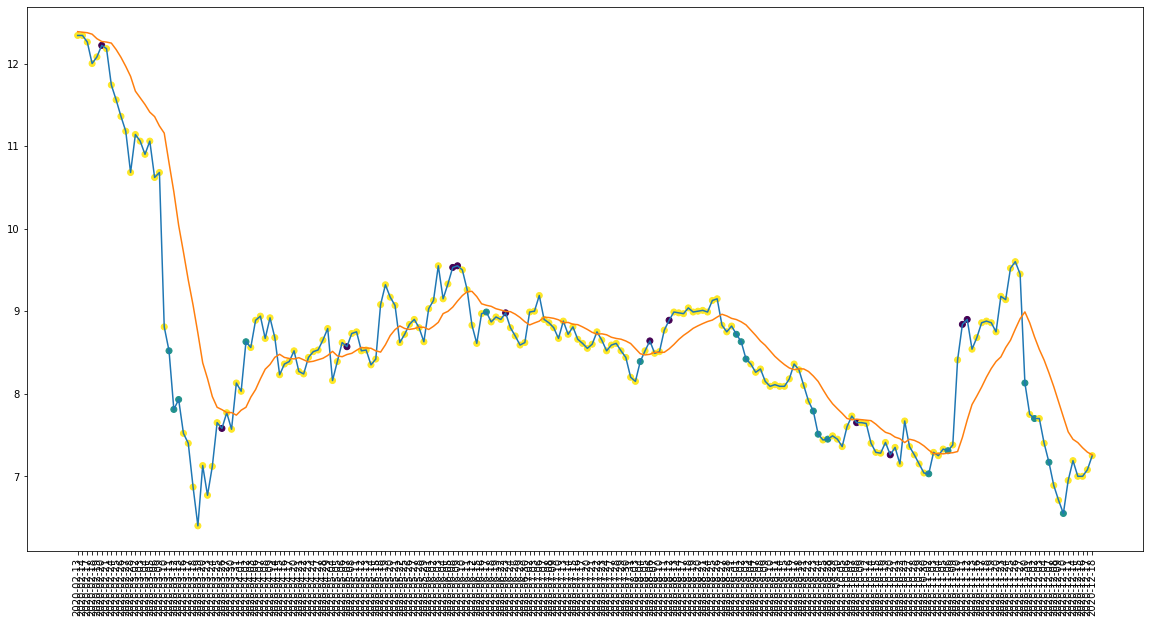

In [1076]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

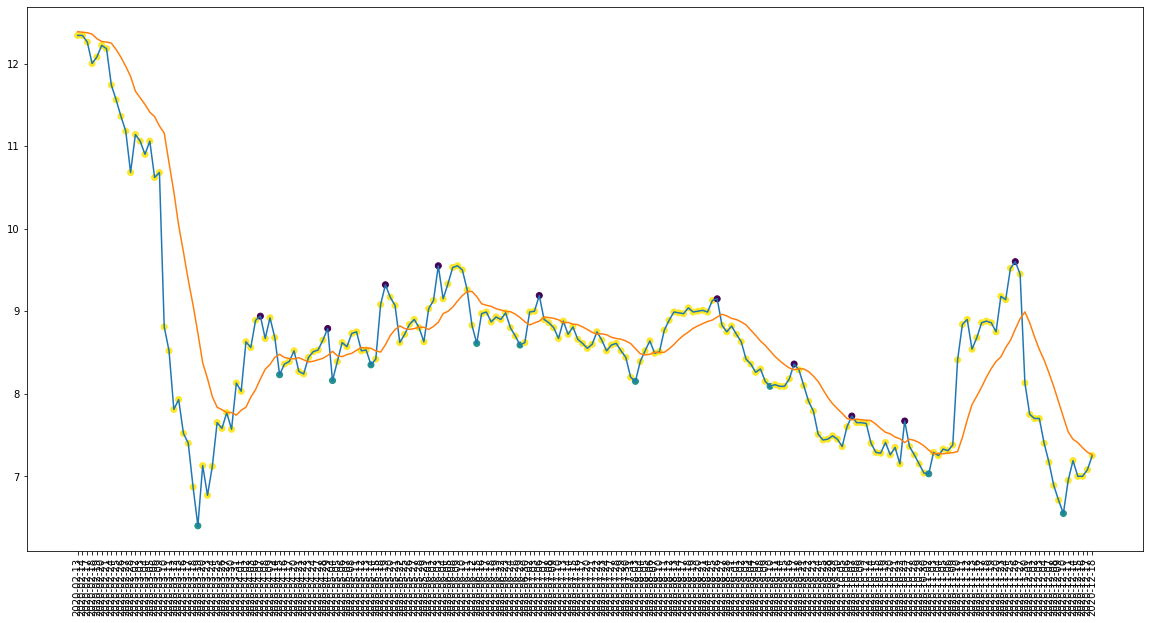

In [1077]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [1078]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 12
actual predicted holds: 165
Percentage buys correct: 20.0%
Percentage sells correct: 0.0%
Percentage holds correct: 85.49222797927462%
actual buys: 10
actual sells: 10
actual holds: 193


In [1079]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 38.888888888888886%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 81.86813186813187%


In [1080]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.520000457763674
Shares owned at the moment: 1170
Cash capital at the moment: $4.1863629436466


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $9116.757621179817


Share price: $7.809999942779541
Shares owned at the moment: 1164
Cash capital at the moment: $0.9178779675930855


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $8730.12633582711


Share price: $8.630000114440918
Shares owned at the moment: 1008
Cash capital at the moment: $7.163860153434143


Stop Loss Activated!

Share price: $8.229999542236326
Shares owned at the moment: 0
Cash capital at the moment: $8280.189839996572


Share price: $8.989999771118164
Shares owned at the moment: 918
Cash capital at the moment: $4.674795687909864


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $7969.311471074817


Share price: $8

In [1081]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [1107]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


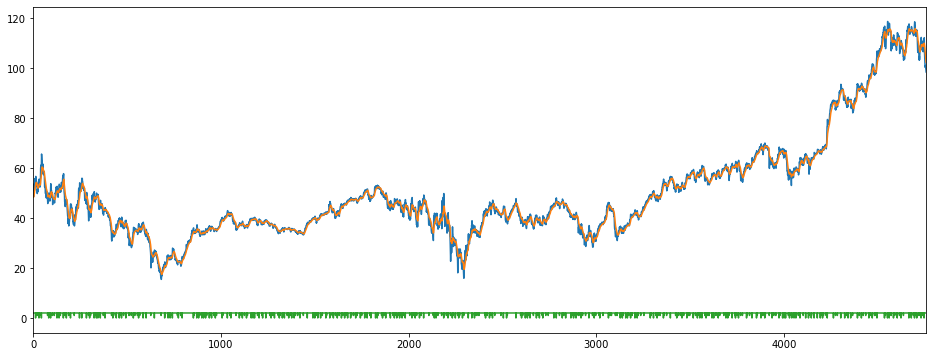

In [1108]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [1109]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0

In [1110]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [1111]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [1112]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [1113]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4740, 64, 64, 1)

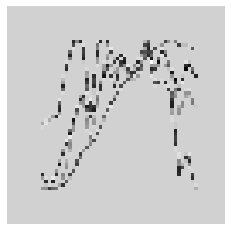

In [1114]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [1115]:
X = X/255

In [1116]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [1117]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [1118]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [1195]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [1196]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[0 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.7073170731707314, 1: 7.391812865497076, 2: 0.3656349435927104}
Epoch 1/200
30/30 [==============================] - 2s 66ms/step - loss: 0.2542 - accuracy: 0.2890 - mse: 1.6772 - weighted_accuracy: 0.3226 - weighted_mse: 1.7715 - val_loss: 0.1996 - val_accuracy: 0.0485 - val_mse: 1.1775 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 1.1775
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2068 - accuracy: 0.4014 - mse: 1.1793 - weighted_accuracy: 0.3344 - weighted_mse: 1.2031 - val_loss: 0.1995 - val_accuracy: 0.4905 - val_mse: 0.8384 - val_weighted_accuracy: 0.4905 - val_weighted_mse: 0.8384
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2019 - accuracy: 0.3945 - mse: 1.1751 - weighted_accuracy: 0.3732 - weighted_mse: 1.1876 - val_loss: 0.1983 - val_accuracy: 0.0506 - val_mse: 1.0671 - val_weighted_accuracy: 0.0506 - val_weighted_mse: 1.0671
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2034 

30/30 [==============================] - 0s 11ms/step - loss: 0.1961 - accuracy: 0.3215 - mse: 1.1766 - weighted_accuracy: 0.3894 - weighted_mse: 1.1774 - val_loss: 0.1965 - val_accuracy: 0.1013 - val_mse: 0.9402 - val_weighted_accuracy: 0.1013 - val_weighted_mse: 0.9402
Epoch 29/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1968 - accuracy: 0.3634 - mse: 1.1793 - weighted_accuracy: 0.3989 - weighted_mse: 1.1714 - val_loss: 0.1904 - val_accuracy: 0.3122 - val_mse: 0.9988 - val_weighted_accuracy: 0.3122 - val_weighted_mse: 0.9988
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1975 - accuracy: 0.3304 - mse: 1.2143 - weighted_accuracy: 0.3680 - weighted_mse: 1.1858 - val_loss: 0.2000 - val_accuracy: 0.0675 - val_mse: 0.9024 - val_weighted_accuracy: 0.0675 - val_weighted_mse: 0.9024
Epoch 31/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1969 - accuracy: 0.3391 - mse: 1.1781 - weighted_accuracy: 0.3749 - weighted_mse: 

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1834 - accuracy: 0.2371 - mse: 1.2356 - weighted_accuracy: 0.4725 - weighted_mse: 1.2175 - val_loss: 0.1894 - val_accuracy: 0.2205 - val_mse: 1.0141 - val_weighted_accuracy: 0.2205 - val_weighted_mse: 1.0141
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1825 - accuracy: 0.2310 - mse: 1.2481 - weighted_accuracy: 0.4762 - weighted_mse: 1.2218 - val_loss: 0.1857 - val_accuracy: 0.2500 - val_mse: 1.1067 - val_weighted_accuracy: 0.2500 - val_weighted_mse: 1.1067
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1818 - accuracy: 0.2408 - mse: 1.2554 - weighted_accuracy: 0.4735 - weighted_mse: 1.2183 - val_loss: 0.1920 - val_accuracy: 0.1308 - val_mse: 1.1128 - val_weighted_accuracy: 0.1308 - val_weighted_mse: 1.1128
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1800 - accuracy: 0.2255 - mse: 1.2716 - weighted_accuracy: 0.4924 - w

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1571 - accuracy: 0.2086 - mse: 1.4004 - weighted_accuracy: 0.6045 - weighted_mse: 1.3610 - val_loss: 0.1786 - val_accuracy: 0.3027 - val_mse: 1.2639 - val_weighted_accuracy: 0.3027 - val_weighted_mse: 1.2639
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1608 - accuracy: 0.2186 - mse: 1.4675 - weighted_accuracy: 0.5882 - weighted_mse: 1.4193 - val_loss: 0.1939 - val_accuracy: 0.2257 - val_mse: 1.2659 - val_weighted_accuracy: 0.2257 - val_weighted_mse: 1.2659
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1584 - accuracy: 0.2104 - mse: 1.4916 - weighted_accuracy: 0.5960 - weighted_mse: 1.4738 - val_loss: 0.1922 - val_accuracy: 0.1920 - val_mse: 1.2529 - val_weighted_accuracy: 0.1920 - val_weighted_mse: 1.2529
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1552 - accuracy: 0.2294 - mse: 1.4970 - weighted_accuracy: 0.6182 - we

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1316 - accuracy: 0.4262 - mse: 1.8303 - weighted_accuracy: 0.7310 - weighted_mse: 1.8940 - val_loss: 0.1766 - val_accuracy: 0.4504 - val_mse: 1.5798 - val_weighted_accuracy: 0.4504 - val_weighted_mse: 1.5798
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1310 - accuracy: 0.4391 - mse: 1.8431 - weighted_accuracy: 0.7224 - weighted_mse: 1.9146 - val_loss: 0.1735 - val_accuracy: 0.4800 - val_mse: 1.5905 - val_weighted_accuracy: 0.4800 - val_weighted_mse: 1.5905
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1281 - accuracy: 0.4280 - mse: 1.8235 - weighted_accuracy: 0.7185 - weighted_mse: 1.9258 - val_loss: 0.1692 - val_accuracy: 0.5074 - val_mse: 1.5990 - val_weighted_accuracy: 0.5074 - val_weighted_mse: 1.5990
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1317 - accuracy: 0.4383 - mse: 1.8669 - weighted_accuracy: 0.7241 

Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1048 - accuracy: 0.6079 - mse: 2.3449 - weighted_accuracy: 0.7898 - weighted_mse: 2.7936 - val_loss: 0.1422 - val_accuracy: 0.6709 - val_mse: 1.8368 - val_weighted_accuracy: 0.6709 - val_weighted_mse: 1.8368
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1082 - accuracy: 0.6097 - mse: 2.2411 - weighted_accuracy: 0.7958 - weighted_mse: 2.6377 - val_loss: 0.1399 - val_accuracy: 0.6825 - val_mse: 1.9206 - val_weighted_accuracy: 0.6825 - val_weighted_mse: 1.9206
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1055 - accuracy: 0.6150 - mse: 2.3356 - weighted_accuracy: 0.7998 - weighted_mse: 2.7663 - val_loss: 0.1386 - val_accuracy: 0.6962 - val_mse: 1.9589 - val_weighted_accuracy: 0.6962 - val_weighted_mse: 1.9589
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1053 - accuracy: 0.6329 - mse: 2.3743 - weighted_accuracy: 0.7890

Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0851 - accuracy: 0.7155 - mse: 3.1589 - weighted_accuracy: 0.8498 - weighted_mse: 4.0331 - val_loss: 0.1226 - val_accuracy: 0.7553 - val_mse: 2.3392 - val_weighted_accuracy: 0.7553 - val_weighted_mse: 2.3392
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0895 - accuracy: 0.7228 - mse: 3.0017 - weighted_accuracy: 0.8351 - weighted_mse: 3.7156 - val_loss: 0.1174 - val_accuracy: 0.7795 - val_mse: 2.4474 - val_weighted_accuracy: 0.7795 - val_weighted_mse: 2.4474
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0908 - accuracy: 0.7244 - mse: 3.0130 - weighted_accuracy: 0.8185 - weighted_mse: 3.7560 - val_loss: 0.1169 - val_accuracy: 0.7806 - val_mse: 2.3953 - val_weighted_accuracy: 0.7806 - val_weighted_mse: 2.3953
Epoch 176/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0862 - accuracy: 0.7168 - mse: 3.0214 - weighted_accuracy: 0.836

In [1197]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10838621109724045
Test accuracy: 0.8196202516555786


In [1198]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.4197552  -0.8755601  -0.03469697]
 [-0.600277   -4.8692327  -0.178333  ]
 [-0.9895619  -2.5325007   0.19158398]
 ...
 [-1.9514751  -1.9398239   0.31986332]
 [-1.6269759  -2.007217    0.30279845]
 [-1.5580573  -1.7447915   0.24522494]]


Counter({2: 845, 0: 71, 1: 32})

In [1199]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 41, 1: 43})

In [1200]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 948
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 37
actual holds but predicted buy: 28
actual holds but predicted sell: 67
actual predicted holds: 769
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 9.75609756097561%
Percentage holds correct: 89.00462962962963%
actual buys: 43
actual sells: 41
actual holds: 864


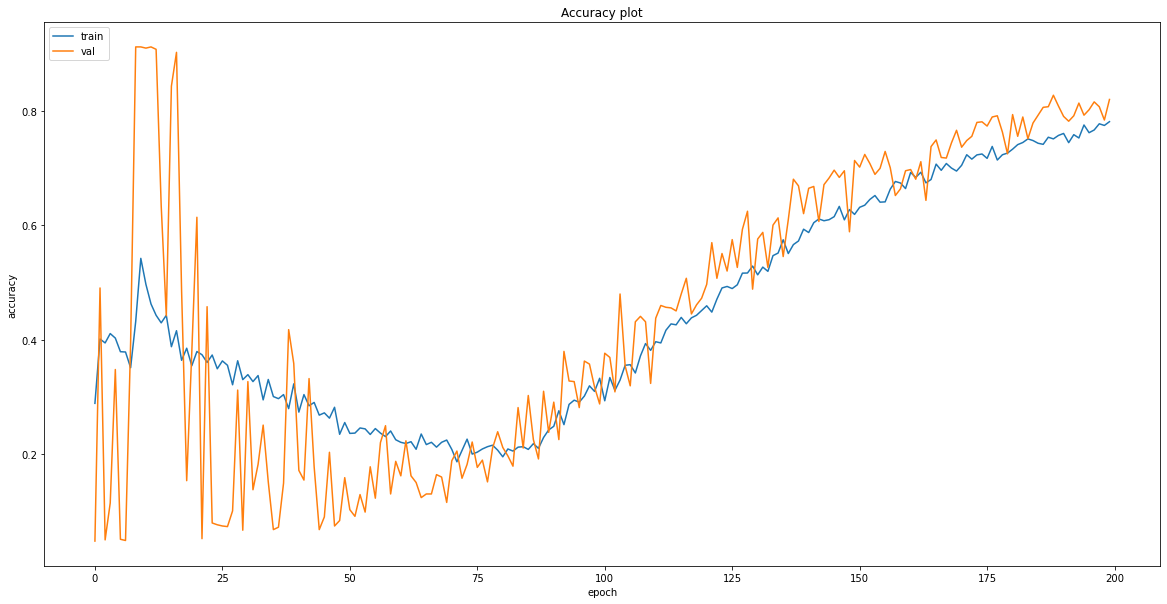

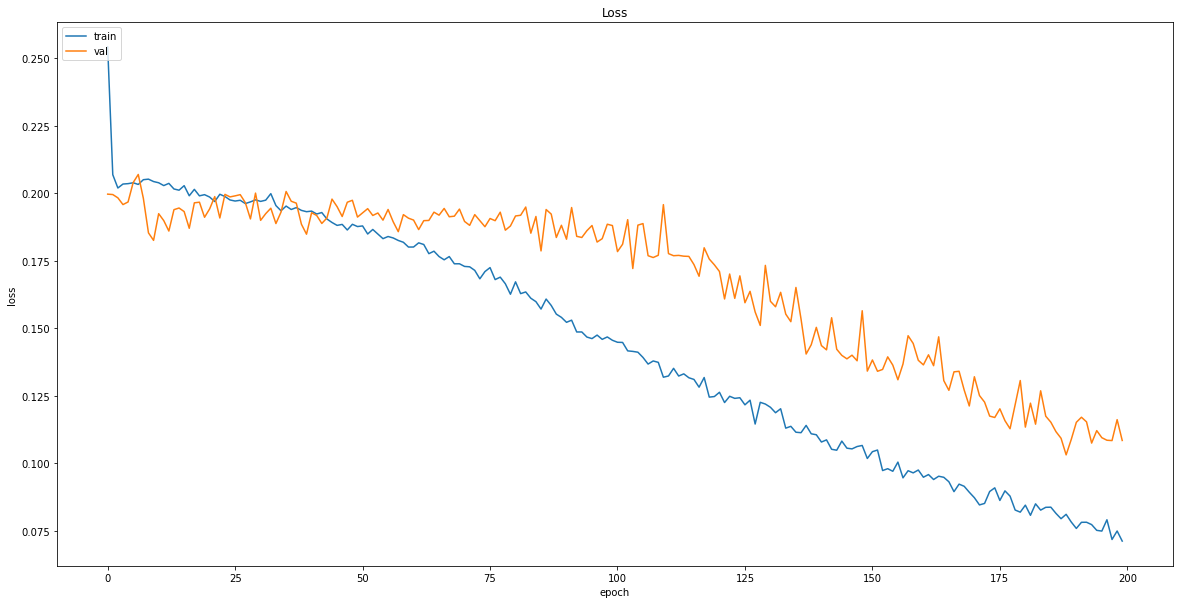

In [1201]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [1202]:
# Save model
model.save("models/{}".format('jpm_image_cnn_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/jpm_image_cnn_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [1203]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2018-12-13   101.019997  105.247250 -87.215299 -1.989079e+09     2.0
2018-12-14   101.120003  104.612289 -86.480500 -1.971828e+09     2.0
2018-12-17   100.290001  103.947322 -92.578971 -1.991708e+09     2.0
2018-12-18    99.010002  103.187734 -96.055365 -2.016821e+09     2.0
2018-12-19    98.540001  102.472698 -97.156410 -2.037658e+09     2.0

In [1204]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [1205]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [1206]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [1207]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [1208]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1190 - accuracy: 0.7661 - mean_squared_error: 3.2229 - weighted_accuracy: 0.7661 - weighted_mean_squared_error: 3.2229
Test loss: 0.11901474744081497
Test accuracy: 0.7660550475120544


In [1209]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 1: 10, 0: 28})

In [1210]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [1211]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-1211-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-1211-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-1211-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-11   100.879997  102.975915 -74.903417  73097300.0     1.0   
2019-02-12   102.599998  102.653466 -84.169891  62118800.0     2.0   
2019-02-13   103.089996  102.645240 -50.965236  74971100.0     2.0   
2019-02-14   102.419998  102.713664 -41.505819  85725200.0     2.0   
2019-02-15   105.550003  102.668485 -54.440145  74206700.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       1  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

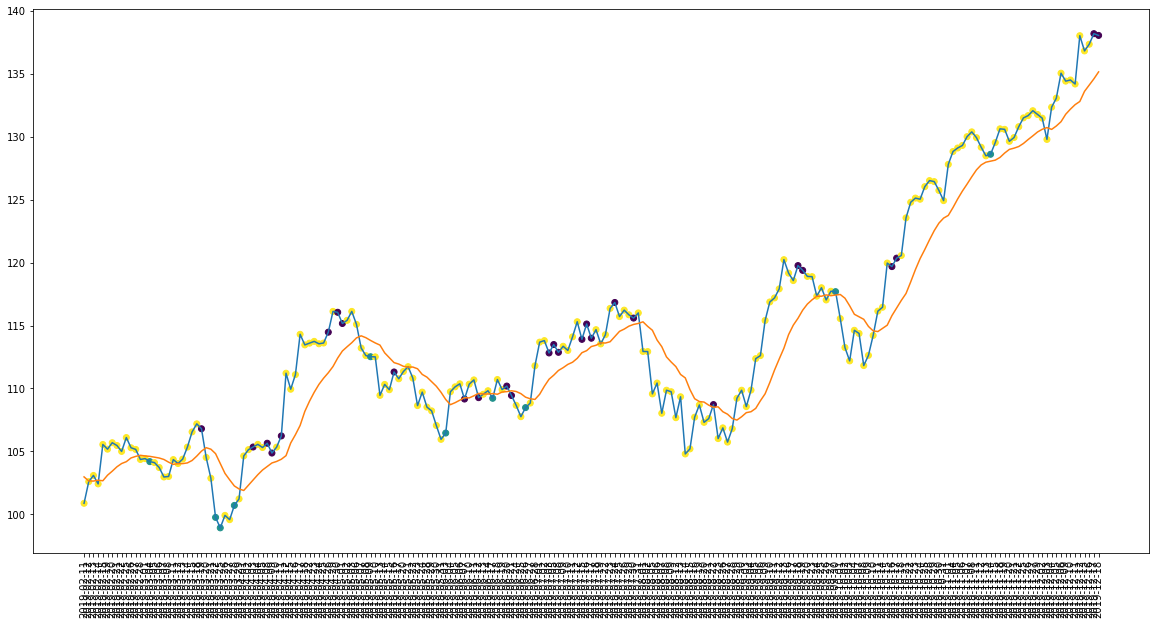

In [1212]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

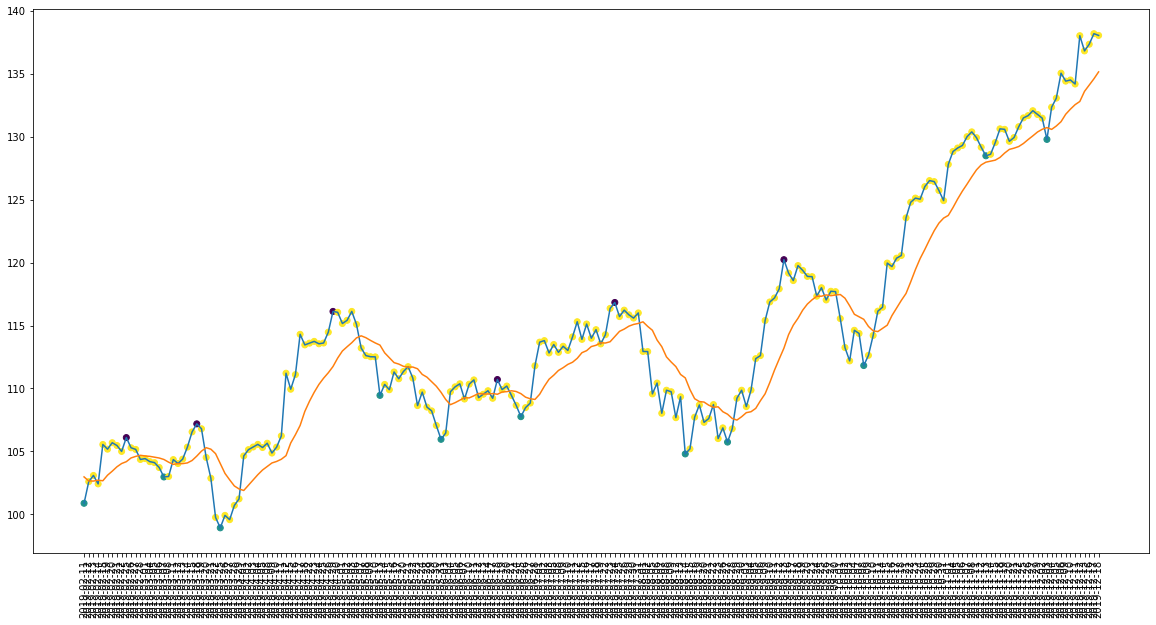

In [1213]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [1214]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 9
actual holds but predicted sell: 27
actual predicted holds: 165
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 82.08955223880596%
actual buys: 11
actual sells: 6
actual holds: 201


In [1215]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 60.0%
Percentage sells correct: 53.57142857142857%
Percentage holds correct: 86.03351955307262%


In [1216]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $104.19000244140624
Shares owned at the moment: 95
Cash capital at the moment: $74.73012992859003


Stop Loss Activated!

Share price: $99.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9525.868032312395


Share price: $99.76000213623048
Shares owned at the moment: 95
Cash capital at the moment: $22.60552881240801


Price increase from previously bought: 5.313831448468709%
Share price: $105.3499984741211
Shares owned at the moment: 0
Cash capital at the moment: $10003.332696752548


Share price: $112.5199966430664
Shares owned at the moment: 88
Cash capital at the moment: $74.34315297508147


Stop Loss Activated!

Share price: $108.63999938964844
Shares owned at the moment: 0
Cash capital at the moment: $9608.372219411849


Share price: $106.45999908447266
Shares owned at the moment: 90
Cash capital at the moment: $0.6234520359030284


Price increase from previously bought: 5.6834459182821595%
Share price: $112.81999969482422
Shares owned at the 

In [1217]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [1218]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-12-13   138.020004  133.597310  -4.554623  284280700.0     2.0
2019-12-16   136.809998  134.091570 -19.726594  273688600.0     2.0
2019-12-17   137.339996  134.591328 -14.634146  285060600.0     2.0
2019-12-18   138.179993  135.143430  -6.439060  296607400.0     2.0
2019-12-19   138.039993  135.589055  -9.396071  286225900.0     2.0

In [1219]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [1220]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [1221]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [1222]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [1223]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1146 - accuracy: 0.8037 - mean_squared_error: 3.2079 - weighted_accuracy: 0.8037 - weighted_mean_squared_error: 3.2079
Test loss: 0.11460980027914047
Test accuracy: 0.8036529421806335


In [1224]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 0: 22, 1: 7})

In [1225]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [1226]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-1226-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-1226-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-1226-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   138.000000  136.179383  -6.410124  26757600.0     0.0   
2020-02-12   138.000000  136.459478  -9.001177  33336200.0     2.0   
2020-02-13   137.880005  136.696481 -13.465502  33336200.0     2.0   
2020-02-14   137.460007  136.878562 -14.718062  25888700.0     2.0   
2020-02-18   135.639999  136.968015 -23.401387  19261100.0     2.0   

            predictions  actual  
Date                             
2020-02-11            2       0  
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            2       2

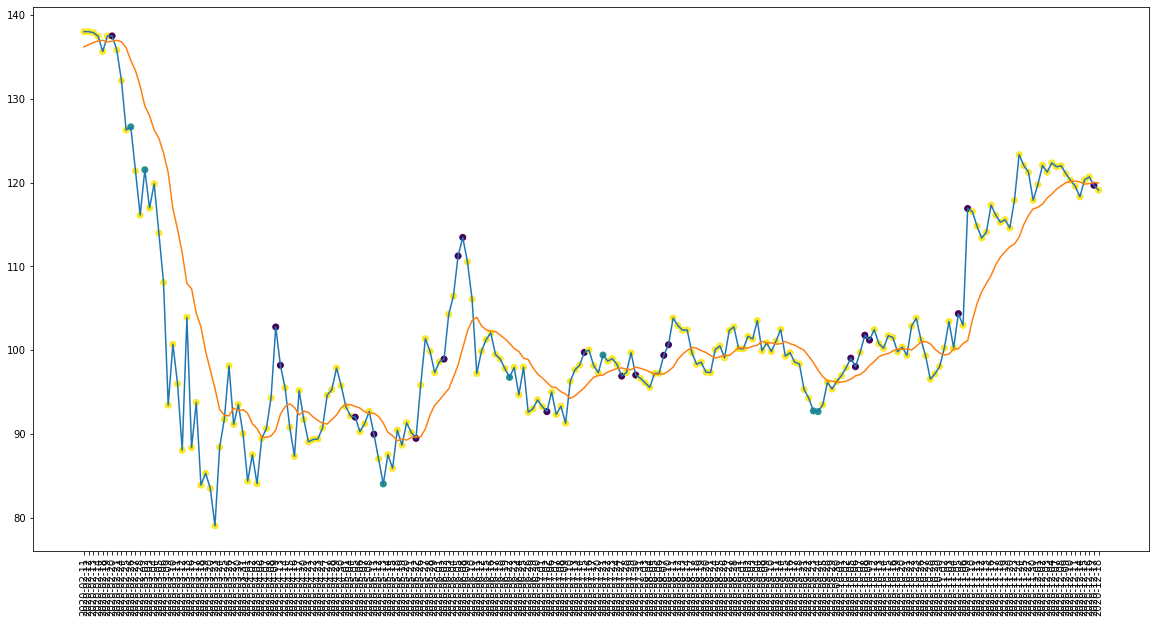

In [1227]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

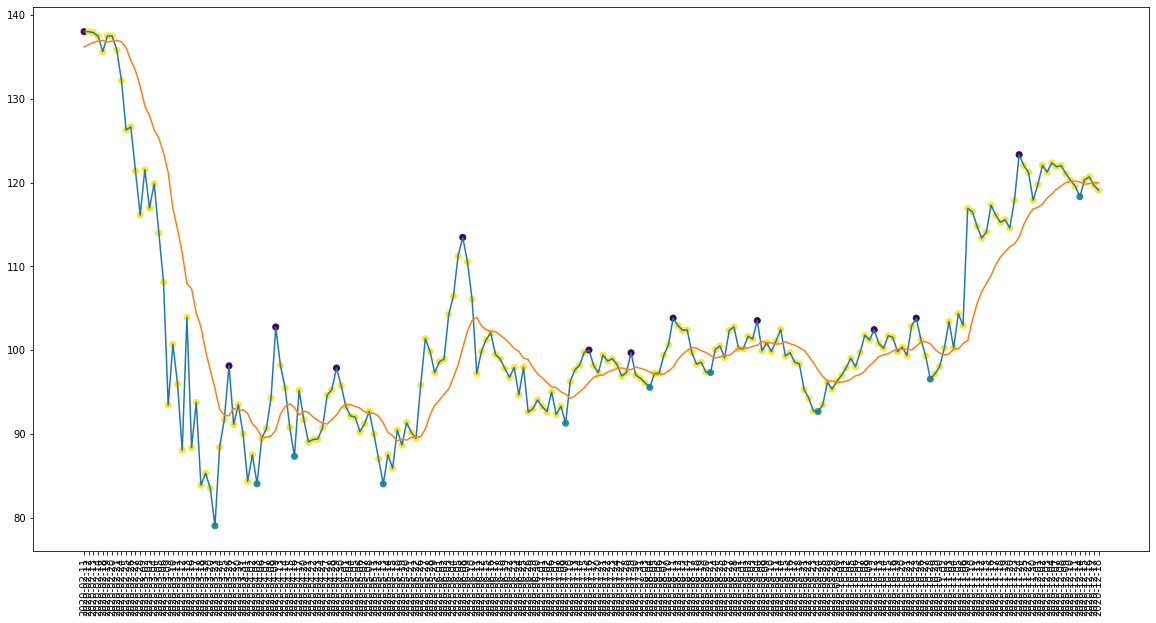

In [1228]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [1229]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 5
actual holds but predicted sell: 20
actual predicted holds: 172
Percentage buys correct: 20.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 87.30964467005076%
actual buys: 10
actual sells: 12
actual holds: 197


In [1230]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 82.53968253968254%


In [1231]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $126.63999938964844
Shares owned at the moment: 78
Cash capital at the moment: $94.91576773834277


Stop Loss Activated!

Share price: $121.37000274658205
Shares owned at the moment: 0
Cash capital at the moment: $9535.7421163826


Share price: $121.5199966430664
Shares owned at the moment: 78
Cash capital at the moment: $31.116338943482333


Stop Loss Activated!

Share price: $116.95999908447266
Shares owned at the moment: 0
Cash capital at the moment: $9128.90834772873


Share price: $84.02999877929688
Shares owned at the moment: 108
Cash capital at the moment: $28.71156992721626


Price increase from previously bought: 6.181881202906592%
Share price: $89.47000122070312
Shares owned at the moment: 0
Cash capital at the moment: $9664.899111400604


Share price: $96.75
Shares owned at the moment: 99
Cash capital at the moment: $60.308923900603986


Stop Loss Activated!

Share price: $92.58999633789062
Shares owned at the moment: 0
Cash capital at the moment: $9201.51093484

In [1232]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [726]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


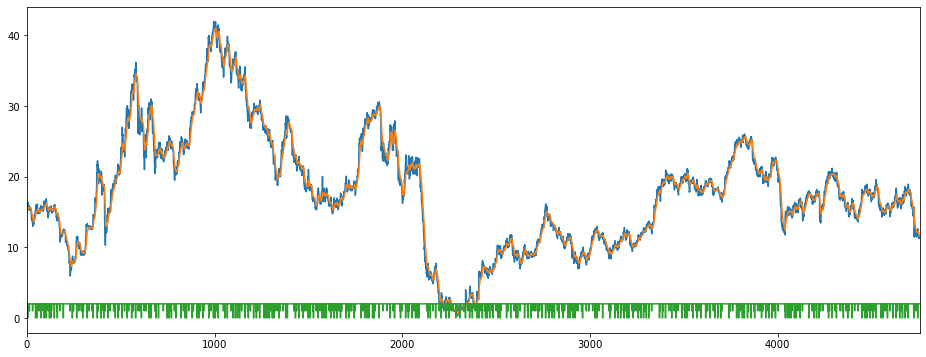

In [727]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [728]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0

In [729]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [730]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [731]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
y = np.array(y)

X.shape

(4740, 64, 64, 1)

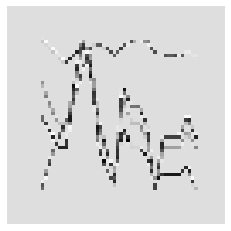

In [732]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [733]:
X = X/255

In [734]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [735]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [736]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [964]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [965]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
# d_class_weights[0] = 7
# d_class_weights[1] = 7
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.264367816091954, 1: 7.30635838150289, 2: 0.3669085631349782}
Epoch 1/200
30/30 [==============================] - 2s 66ms/step - loss: 0.2493 - accuracy: 0.4773 - mse: 1.5588 - weighted_accuracy: 0.3395 - weighted_mse: 1.6885 - val_loss: 0.1890 - val_accuracy: 0.8850 - val_mse: 0.8168 - val_weighted_accuracy: 0.8850 - val_weighted_mse: 0.8168
Epoch 2/200
30/30 [==============================] - 0s 12ms/step - loss: 0.2087 - accuracy: 0.4818 - mse: 1.1359 - weighted_accuracy: 0.3375 - weighted_mse: 1.1632 - val_loss: 0.1801 - val_accuracy: 0.8945 - val_mse: 0.9283 - val_weighted_accuracy: 0.8945 - val_weighted_mse: 0.9283
Epoch 3/200
30/30 [==============================] - 0s 14ms/step - loss: 0.2110 - accuracy: 0.3476 - mse: 1.1733 - weighted_accuracy: 0.3175 - weighted_mse: 1.1616 - val_loss: 0.1897 - val_accuracy: 0.6593 - val_mse: 1.0470 - val_weighted_accuracy: 0.6593 - val_weighted_mse: 1.0470
Epoch 4/200
30/30 [==============================] - 0s 12ms/step - loss: 0.2072 

30/30 [==============================] - 0s 12ms/step - loss: 0.1962 - accuracy: 0.2706 - mse: 1.1799 - weighted_accuracy: 0.4222 - weighted_mse: 1.1481 - val_loss: 0.1932 - val_accuracy: 0.1857 - val_mse: 1.1311 - val_weighted_accuracy: 0.1857 - val_weighted_mse: 1.1311
Epoch 29/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1962 - accuracy: 0.2634 - mse: 1.1778 - weighted_accuracy: 0.4122 - weighted_mse: 1.1782 - val_loss: 0.1942 - val_accuracy: 0.1635 - val_mse: 1.0590 - val_weighted_accuracy: 0.1635 - val_weighted_mse: 1.0590
Epoch 30/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1993 - accuracy: 0.2384 - mse: 1.2265 - weighted_accuracy: 0.3994 - weighted_mse: 1.2014 - val_loss: 0.2000 - val_accuracy: 0.1044 - val_mse: 0.9932 - val_weighted_accuracy: 0.1044 - val_weighted_mse: 0.9932
Epoch 31/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1977 - accuracy: 0.2903 - mse: 1.1667 - weighted_accuracy: 0.4202 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1744 - accuracy: 0.1941 - mse: 1.2757 - weighted_accuracy: 0.5238 - weighted_mse: 1.2436 - val_loss: 0.1949 - val_accuracy: 0.1951 - val_mse: 1.1370 - val_weighted_accuracy: 0.1951 - val_weighted_mse: 1.1370
Epoch 58/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1748 - accuracy: 0.1973 - mse: 1.2548 - weighted_accuracy: 0.5267 - weighted_mse: 1.2176 - val_loss: 0.1977 - val_accuracy: 0.2078 - val_mse: 1.1154 - val_weighted_accuracy: 0.2078 - val_weighted_mse: 1.1154
Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1710 - accuracy: 0.2107 - mse: 1.2952 - weighted_accuracy: 0.5682 - weighted_mse: 1.2664 - val_loss: 0.1969 - val_accuracy: 0.1719 - val_mse: 1.0842 - val_weighted_accuracy: 0.1719 - val_weighted_mse: 1.0842
Epoch 60/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1708 - accuracy: 0.2025 - mse: 1.3008 - weighted_accuracy: 0.5306 - 

Epoch 86/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1507 - accuracy: 0.2645 - mse: 1.4473 - weighted_accuracy: 0.6172 - weighted_mse: 1.4391 - val_loss: 0.1924 - val_accuracy: 0.2669 - val_mse: 1.2832 - val_weighted_accuracy: 0.2669 - val_weighted_mse: 1.2832
Epoch 87/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1505 - accuracy: 0.2708 - mse: 1.4694 - weighted_accuracy: 0.5938 - weighted_mse: 1.4601 - val_loss: 0.1893 - val_accuracy: 0.2922 - val_mse: 1.3491 - val_weighted_accuracy: 0.2922 - val_weighted_mse: 1.3491
Epoch 88/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1519 - accuracy: 0.2811 - mse: 1.4540 - weighted_accuracy: 0.5957 - weighted_mse: 1.4639 - val_loss: 0.1923 - val_accuracy: 0.2679 - val_mse: 1.2970 - val_weighted_accuracy: 0.2679 - val_weighted_mse: 1.2970
Epoch 89/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1544 - accuracy: 0.2751 - mse: 1.4683 - weighted_accuracy: 0.5845 - 

Epoch 115/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1410 - accuracy: 0.3766 - mse: 1.6577 - weighted_accuracy: 0.6345 - weighted_mse: 1.7408 - val_loss: 0.1775 - val_accuracy: 0.4251 - val_mse: 1.4396 - val_weighted_accuracy: 0.4251 - val_weighted_mse: 1.4396
Epoch 116/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1392 - accuracy: 0.3903 - mse: 1.6275 - weighted_accuracy: 0.6449 - weighted_mse: 1.7371 - val_loss: 0.1801 - val_accuracy: 0.4040 - val_mse: 1.4120 - val_weighted_accuracy: 0.4040 - val_weighted_mse: 1.4120
Epoch 117/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1386 - accuracy: 0.3737 - mse: 1.6238 - weighted_accuracy: 0.6444 - weighted_mse: 1.7220 - val_loss: 0.1769 - val_accuracy: 0.4536 - val_mse: 1.4930 - val_weighted_accuracy: 0.4536 - val_weighted_mse: 1.4930
Epoch 118/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1349 - accuracy: 0.3848 - mse: 1.6553 - weighted_accuracy: 0.652

Epoch 144/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1242 - accuracy: 0.5071 - mse: 1.9114 - weighted_accuracy: 0.7042 - weighted_mse: 2.2411 - val_loss: 0.1620 - val_accuracy: 0.5823 - val_mse: 1.6758 - val_weighted_accuracy: 0.5823 - val_weighted_mse: 1.6758
Epoch 145/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1172 - accuracy: 0.5185 - mse: 1.9575 - weighted_accuracy: 0.7486 - weighted_mse: 2.4468 - val_loss: 0.1615 - val_accuracy: 0.5823 - val_mse: 1.6945 - val_weighted_accuracy: 0.5823 - val_weighted_mse: 1.6945
Epoch 146/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1219 - accuracy: 0.5164 - mse: 1.9234 - weighted_accuracy: 0.7277 - weighted_mse: 2.3106 - val_loss: 0.1661 - val_accuracy: 0.5401 - val_mse: 1.6695 - val_weighted_accuracy: 0.5401 - val_weighted_mse: 1.6695
Epoch 147/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1220 - accuracy: 0.5150 - mse: 1.9407 - weighted_accuracy: 0.712

Epoch 173/200
30/30 [==============================] - 0s 14ms/step - loss: 0.0989 - accuracy: 0.6429 - mse: 2.4503 - weighted_accuracy: 0.8198 - weighted_mse: 3.4171 - val_loss: 0.1418 - val_accuracy: 0.7131 - val_mse: 1.9996 - val_weighted_accuracy: 0.7131 - val_weighted_mse: 1.9996
Epoch 174/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1013 - accuracy: 0.6400 - mse: 2.4323 - weighted_accuracy: 0.7986 - weighted_mse: 3.3928 - val_loss: 0.1431 - val_accuracy: 0.7025 - val_mse: 1.9792 - val_weighted_accuracy: 0.7025 - val_weighted_mse: 1.9792
Epoch 175/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1024 - accuracy: 0.6532 - mse: 2.4142 - weighted_accuracy: 0.8162 - weighted_mse: 3.3792 - val_loss: 0.1408 - val_accuracy: 0.7162 - val_mse: 2.0233 - val_weighted_accuracy: 0.7162 - val_weighted_mse: 2.0233
Epoch 176/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1029 - accuracy: 0.6369 - mse: 2.4327 - weighted_accuracy: 0.802

In [966]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1227504163980484
Test accuracy: 0.7911392450332642


In [967]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.9900117  -1.0125604  -0.16312248]
 [-1.4227971  -1.845037   -0.08507376]
 [-0.8381458  -1.7261529  -0.2016339 ]
 ...
 [-0.9338421  -1.538259   -0.19094193]
 [-1.2187383  -1.7298927  -0.11357626]
 [-1.4131737  -1.257509   -0.10660595]]


Counter({2: 810, 1: 85, 0: 53})

In [968]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 861, 0: 43, 1: 44})

In [969]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 948
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 39
actual holds but predicted buy: 73
actual holds but predicted sell: 50
actual predicted holds: 738
Percentage buys correct: 22.727272727272727%
Percentage sells correct: 4.651162790697675%
Percentage holds correct: 85.71428571428571%
actual buys: 44
actual sells: 43
actual holds: 861


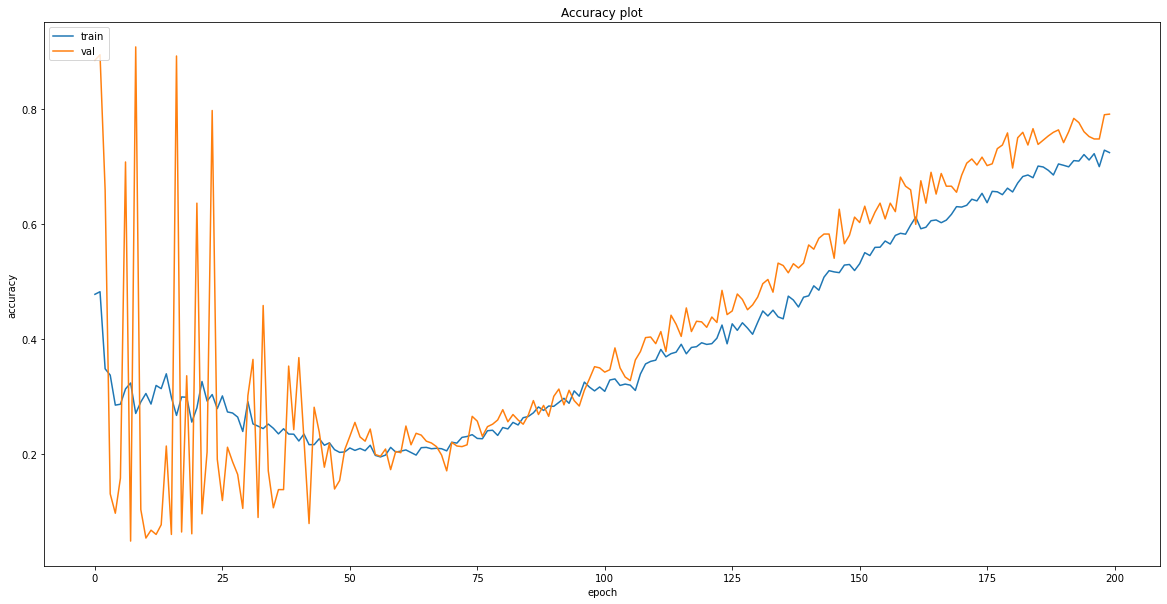

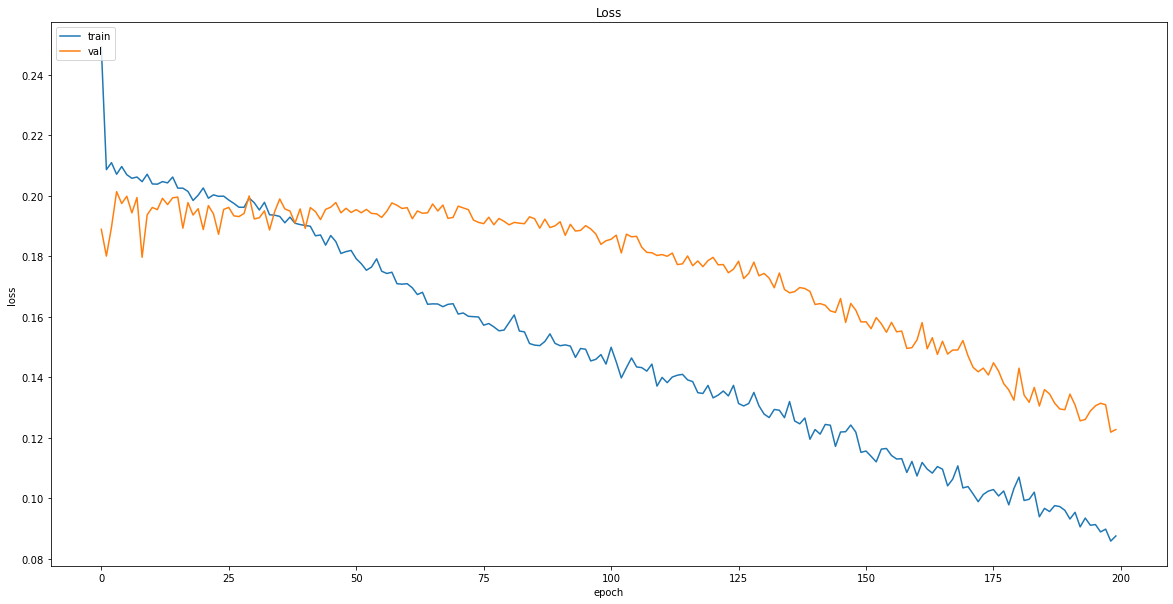

In [970]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [971]:
# Save model
model.save("models/{}".format('axl_image_cnn_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/axl_image_cnn_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [972]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-13        11.52  11.820811 -67.289689  230854400.0     2.0
2018-12-14        11.52  11.774532 -67.289689  230854400.0     2.0
2018-12-17        11.27  11.696912 -78.971930  229177400.0     2.0
2018-12-18        11.25  11.628156 -79.906531  227542600.0     2.0
2018-12-19        11.43  11.597671 -71.495303  229242700.0     2.0

In [973]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [974]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [975]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
X = X/255
y = np.array(y)

In [976]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [977]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1281 - accuracy: 0.7844 - mean_squared_error: 2.5910 - weighted_accuracy: 0.7844 - weighted_mean_squared_error: 2.5910
Test loss: 0.12812179327011108
Test accuracy: 0.7844036817550659


In [978]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 181, 0: 14, 1: 23})

In [979]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [980]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-980-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-980-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-980-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        14.01  14.312907 -83.060094  17347800.0     2.0   
2019-02-12        14.34  14.266306 -68.852439  19189100.0     2.0   
2019-02-13        14.45  14.277643 -50.819664  21493700.0     2.0   
2019-02-14        14.70  14.304160 -44.808757  23008200.0     2.0   
2019-02-15        16.83  14.365058 -31.147561  25735200.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            0       2

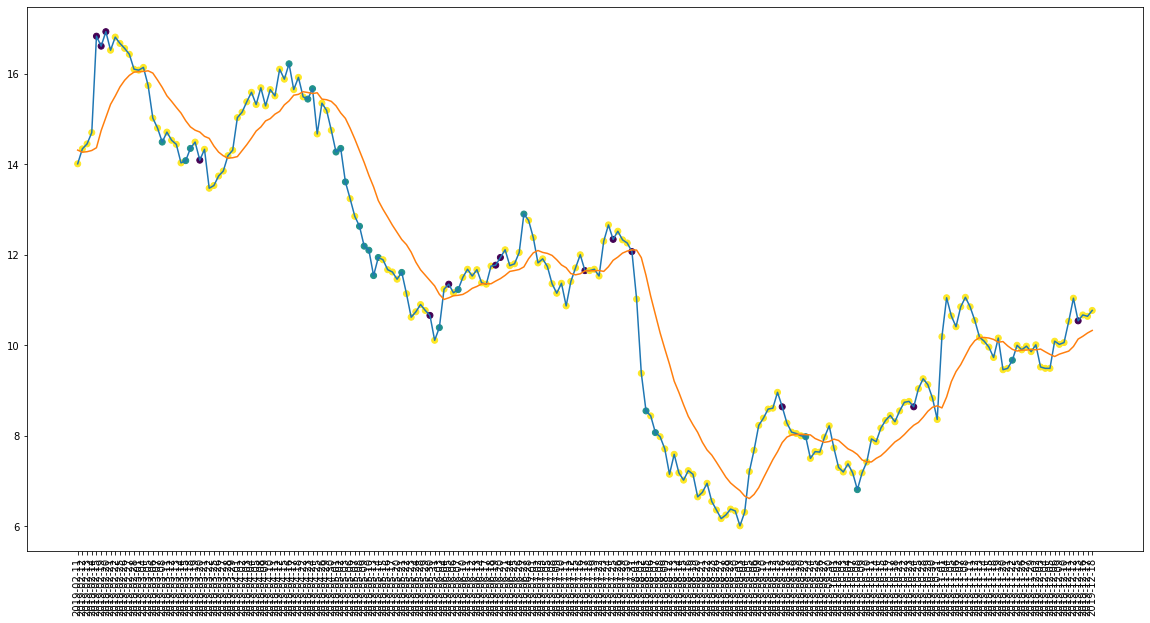

In [981]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

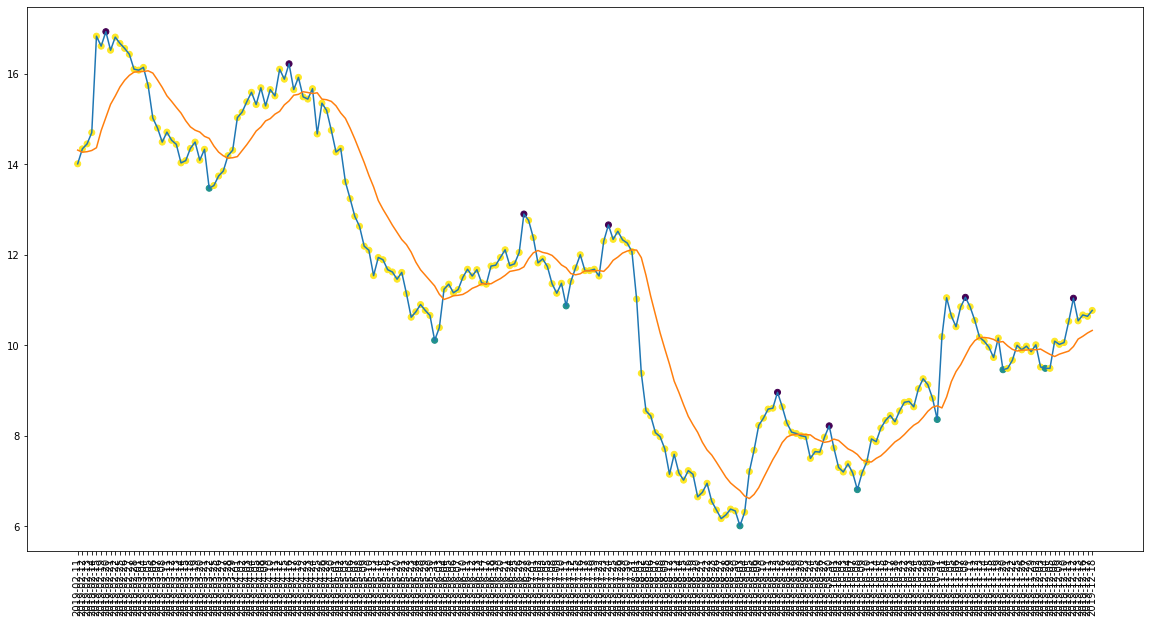

In [982]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [983]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 20
actual holds but predicted sell: 13
actual predicted holds: 169
Percentage buys correct: 12.5%
Percentage sells correct: 12.5%
Percentage holds correct: 83.66336633663366%
actual buys: 8
actual sells: 8
actual holds: 202


In [984]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 39.130434782608695%
Percentage sells correct: 57.142857142857146%
Percentage holds correct: 85.55555555555556%


In [985]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.489999771118164
Shares owned at the moment: 688
Cash capital at the moment: $3.465077903747442


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9629.560134693147


Share price: $14.079999923706055
Shares owned at the moment: 682
Cash capital at the moment: $0.5931468687067536


Stop Loss Activated!

Share price: $13.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $9161.87034348154


Share price: $16.219999313354492
Shares owned at the moment: 563
Cash capital at the moment: $4.898116126059904


Stop Loss Activated!

Share price: $15.649999618530273
Shares owned at the moment: 0
Cash capital at the moment: $8791.617789449214


Share price: $15.4399995803833
Shares owned at the moment: 567
Cash capital at the moment: $13.063208026169377


Stop Loss Activated!

Share price: $14.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8308.079053665875


Share pri

In [986]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [987]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-12-13        11.04  10.136919  -2.162160 -8221900.0     2.0
2019-12-16        10.54  10.198932 -35.467981 -9883500.0     2.0
2019-12-17        10.67  10.271404 -29.064037 -8890800.0     2.0
2019-12-18        10.64  10.328111 -30.541856 -9882500.0     2.0
2019-12-19        10.77  10.396094 -24.137912 -8689200.0     2.0

In [988]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [989]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [990]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [991]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [992]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1256 - accuracy: 0.7900 - mean_squared_error: 2.5901 - weighted_accuracy: 0.7900 - weighted_mean_squared_error: 2.5901
Test loss: 0.1256120204925537
Test accuracy: 0.7899543642997742


In [993]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 189, 1: 16, 0: 14})

In [994]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [995]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-995-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-995-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-995-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-11         9.84  9.643918 -57.638900 -3274300.0     2.0            2   
2020-02-12        10.34  9.674085 -36.805548 -1876100.0     0.0            2   
2020-02-13        10.22  9.776533 -16.568036  -291400.0     2.0            2   
2020-02-14         8.77  9.844759 -23.668622 -1567700.0     2.0            2   
2020-02-18         8.27  9.679411 -90.686248 -6644000.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       0  
2020-02-13       2  
2020-02-14       2  
2020-02-18       2

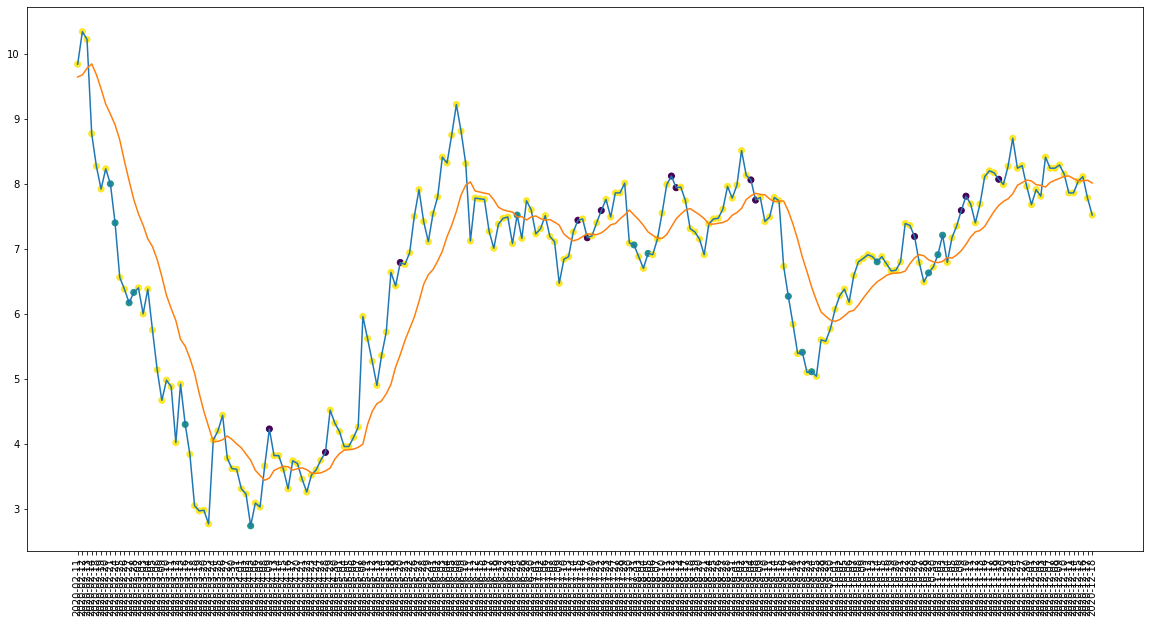

In [996]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

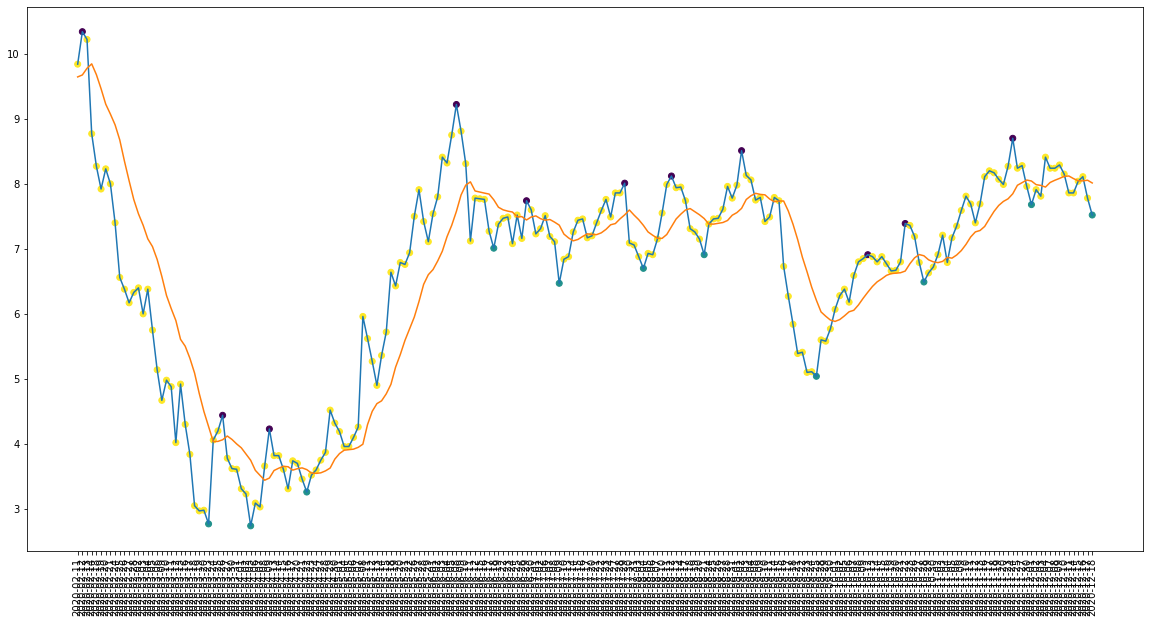

In [997]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [998]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 15
actual holds but predicted sell: 12
actual predicted holds: 170
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 86.29441624365482%
actual buys: 11
actual sells: 11
actual holds: 197


In [999]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 43.75%
Percentage sells correct: 71.42857142857143%
Percentage holds correct: 84.04255319148936%


In [1000]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.0
Shares owned at the moment: 1246
Cash capital at the moment: $4.587999999999738


Stop Loss Activated!

Share price: $7.400000095367432
Shares owned at the moment: 0
Cash capital at the moment: $9199.632018501043


Share price: $7.400000095367432
Shares owned at the moment: 1239
Cash capital at the moment: $5.818250015854574


Stop Loss Activated!

Share price: $6.559999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8111.30661931467


Share price: $6.170000076293945
Shares owned at the moment: 1311
Cash capital at the moment: $0.1921265182481875


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $7844.560626518248


Share price: $4.300000190734863
Shares owned at the moment: 1819
Cash capital at the moment: $1.3506036174276232


Stop Loss Activated!

Share price: $3.839999914169312
Shares owned at the moment: 0
Cash capital at the moment: $6967.101807920752


Share price: $2.740000009536743
Shares 

In [1001]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
